In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the dataset
df = pd.read_csv("not_final3.csv")
df = df.rename(columns={'Sport_-1': 'Sport'})

# List of sports to exclude
excluded_sports = ['climbing', 'Fitness', 'Headis']

# Filter out excluded sports
df = df[~df['Sport'].isin(excluded_sports)]

# Define parameters including 'label'
parameters = ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label']

# Initialize a dictionary to store processed data for each sport
sport_data_dict = {}

for sport_name in df['Sport'].unique():
    sport_dict = {'Year': []}
    
    # Initialize a DataFrame for Year
    all_years = pd.Series(dtype=int)
    
    for parameter in parameters:
        param_columns = [col for col in df.columns if col.startswith(f"{parameter}_")]
        
        if not param_columns:
            continue
        
        # Melt the data for this parameter
        melted_data = df[df['Sport'] == sport_name][['Sport'] + param_columns].melt(
            id_vars='Sport', var_name='Year', value_name=f'{parameter}'
        )
        melted_data['Year'] = melted_data['Year'].str.extract(r'(\d+)').astype(int)  # Extract year as int
        melted_data = melted_data.sort_values('Year')

        if all_years.empty:
            all_years = melted_data['Year']
        else:
            all_years = pd.concat([all_years, melted_data['Year']]).drop_duplicates().sort_values()
        
        # Align parameter data with all years
        melted_data = melted_data.set_index('Year').reindex(all_years).reset_index()
        
        # Handle missing data based on parameter type
        if parameter == 'drug':
            melted_data[f'{parameter}'] = melted_data[f'{parameter}'].fillna(0)  # For drug, fill missing with 0
        elif parameter in ['popularity', 'CV']:
            # For popularity and CV, treat 0 as missing and replace with NaN
            melted_data[f'{parameter}'] = melted_data[f'{parameter}'].replace(0, np.nan)
        else:
            # Preserve NaN for other parameters
            melted_data[f'{parameter}'] = melted_data[f'{parameter}']
        
        # Store parameter values aligned by Year
        sport_dict[parameter] = melted_data[f'{parameter}'].values

    # Ensure that Year is included
    sport_dict['Year'] = all_years.values
    
    # Convert the dictionary to a DataFrame
    sport_data_dict[sport_name] = pd.DataFrame(sport_dict)

In [2]:
sport_data_dict['Athletics']

,drug,equity,popularity,normalizedcountry,CV,label
Year,,,,,,
1896,0.0,0.000000,0.278947,0.045,1.001050,1
1900,0.0,0.000000,0.120868,0.085,0.975667,1
1904,0.0,0.000000,0.154497,0.055,0.978102,1
1906,0.0,0.000000,0.271206,0.100,0.892952,1
1908,0.0,0.000000,0.250887,0.100,1.032252,1
1912,0.0,0.000000,0.238119,0.135,1.179248,1
1920,0.0,0.000000,0.197810,0.125,1.024756,1
1924,0.0,0.000000,0.176181,0.200,1.126996,1
1928,0.0,0.130040,0.177969,0.200,1.152680,1


In [2]:


# Initialize a list to store predictions
predictions_data = []

# Loop over each sport and parameter
for sport, df in sport_data_dict.items():
    for parameter in ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV']:
        if parameter not in df.columns:
            continue
        
        # Ensure the Year index is converted to a PeriodIndex with frequency 'Y'
        df.index = pd.PeriodIndex(df['Year'], freq='Y')
        
        # Select parameter data, drop NaNs
        parameter_df = df[[parameter]].dropna()
        
        if len(parameter_df) < 3:
            continue  # Not enough data to model
            
        last_year = parameter_df.index[-1].year
        steps_ahead = 2032 - last_year
        
        if steps_ahead <= 0:
            continue  # Data already includes 2032 or beyond
        
        # Prepare the data
        train_data = parameter_df[parameter]
        
        # Fit ARIMA model
        try:
            arima_model = sm.tsa.ARIMA(train_data, order=(1,1,1))
            arima_model_fit = arima_model.fit()
            arima_forecast = arima_model_fit.forecast(steps=steps_ahead)
            arima_pred_2032 = arima_forecast.iloc[-1]
        except Exception as e:
            arima_pred_2032 = np.nan
        
        # Fit SARIMA model
        try:
            sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,0,1,4))
            sarima_model_fit = sarima_model.fit()
            sarima_forecast = sarima_model_fit.forecast(steps=steps_ahead)
            sarima_pred_2032 = sarima_forecast.iloc[-1]
        except Exception as e:
            sarima_pred_2032 = np.nan
        
        # Fit SARIMAX model (without exogenous variables)
        try:
            sarimax_model = SARIMAX(train_data, order=(1,1,1))
            sarimax_model_fit = sarimax_model.fit()
            sarimax_forecast = sarimax_model_fit.forecast(steps=steps_ahead)
            sarimax_pred_2032 = sarimax_forecast.iloc[-1]
        except Exception as e:
            sarimax_pred_2032 = np.nan
        
        # Collect predictions
        predictions_data.append({
            'Sport': sport,
            'Parameter': parameter,
            'Model': 'ARIMA',
            'Prediction_2032': arima_pred_2032
        })
        predictions_data.append({
            'Sport': sport,
            'Parameter': parameter,
            'Model': 'SARIMA',
            'Prediction_2032': sarima_pred_2032
        })
        predictions_data.append({
            'Sport': sport,
            'Parameter': parameter,
            'Model': 'SARIMAX',
            'Prediction_2032': sarimax_pred_2032
        })

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions_data)
predictions_df.to_csv('predictions_2032.csv', index=False)

print("Predictions for 2032 saved to 'predictions_2032.csv'.")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41513D+00    |proj g|=  3.93017D+01

At iterate    5    f= -1.60386D+00    |proj g|=  1.90889D-01

At iterate   10    f= -1.62527D+00    |proj g|=  4.33098D+00

At iterate   15    f= -1.66382D+00    |proj g|=  1.53939D+00

At iterate   20    f= -1.68621D+00    |proj g|=  1.09461D-01

At iterate   25    f= -1.68937D+00    |proj g|=  4.14953D-01

At iterate   30    f= -1.69234D+00    |proj g|=  2.38096D-01

At iterate   35    f= -1.69251D+00    |proj g|=  9.70711D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -2.70942D+00    |proj g|=  3.23979D+00

At iterate   20    f= -2.71048D+00    |proj g|=  3.88259D-02

At iterate   25    f= -2.71093D+00    |proj g|=  5.37816D-01

At iterate   30    f= -2.71304D+00    |proj g|=  1.08392D+00

At iterate   35    f= -2.71539D+00    |proj g|=  9.13583D-01

At iterate   40    f= -2.71549D+00    |proj g|=  4.93036D-01

At iterate   45    f= -2.71591D+00    |proj g|=  4.46177D-02
  ys=-1.170E-05  -gs= 3.063E-05 BFGS update SKIPPED
  ys=-3.602E-08  -gs= 3.664E-07 BFGS update SKIPPED

At iterate   50    f= -2.71593D+00    |proj g|=  1.69791D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.11809D+00    |proj g|=  3.32300D+02

At iterate    5    f= -2.68642D+00    |proj g|=  4.02618D-02

At iterate   10    f= -2.68653D+00    |proj g|=  2.48040D+00

At iterate   15    f= -2.68775D+00    |proj g|=  3.47679D-02
  ys=-1.715E-07  -gs= 5.681E-08 BFGS update SKIPPED

At iterate   20    f= -2.68782D+00    |proj g|=  7.51842D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     82      2     1     0   7.518D-02 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.99660D+00    |proj g|=  5.65779D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     17      1     0     0   1.219D-03  -1.997D+00
  F =  -1.9969157176129333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.29996D-01    |proj g|=  9.95583D-01

At iterate    5    f= -6.36178D-01    |proj g|=  2.90218D-02

At iterate   10    f= -6.37647D-01    |proj g|=  1.27463D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53274D-01    |proj g|=  6.53131D+00

At iterate    5    f=  2.52812D-01    |proj g|=  1.15229D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     18      1     0     0   1.152D-05   2.528D-01
  F =  0.25281184165844389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.64424D+00    |proj g|=  1.63004D+03
  ys=-1.060E-02  -gs= 1.281E-01 BFGS update SKIPPED

At iterate    5    f= -3.13507D+00    |proj g|=  1.57934D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     35      1     1     0   1.262D+00  -3.135D+00
  F =  -3.1350656451166743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N = 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78443D+00    |proj g|=  2.16424D+02

At iterate    5    f= -2.08489D+00    |proj g|=  3.85722D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     21      1     0     0   3.857D-03  -2.085D+00
  F =  -2.0848932937085181     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -6.35384D-01    |proj g|=  5.49986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     27      1     0     0   5.608D-04  -6.354D-01
  F = -0.63538421630104347     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46172D+00    |proj g|=  6.73173D+03
  ys=-7.749E+00  -gs= 8.822E-01 BFGS update SKIPPED

At iterate    5    f= -2.74508D+00    |proj g|=  3.66426D-01

At iterate   10  

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.77266D+00    |proj g|=  3.07890D+00

At iterate   10    f= -1.82699D+00    |proj g|=  2.93158D-01

At iterate   15    f= -1.82781D+00    |proj g|=  6.89101D-01

At iterate   20    f= -1.82803D+00    |proj g|=  1.67191D-01

At iterate   25    f= -1.83037D+00    |proj g|=  1.22775D+00

At iterate   30    f= -1.83537D+00    |proj g|=  1.20360D-01

At iterate   35    f= -1.83598D+00    |proj g|=  3.30374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     51      1     0     0   5.024D-03  -1.836D+00
  F =  -1.8359797441688706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.25837D+00    |proj g|=  7.52432D-01

At iterate   15    f= -1.29836D+00    |proj g|=  2.06913D-02

At iterate   20    f= -1.30057D+00    |proj g|=  6.49305D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     50      1     0     0   6.404D-02  -1.301D+00
  F =  -1.3005668701146891     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69468D+01    |proj g|=  2.80772D+04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -5.95628D-01    |proj g|=  1.21324D-02

At iterate   30    f= -5.96385D-01    |proj g|=  2.29405D-02

At iterate   35    f= -5.96561D-01    |proj g|=  5.18258D-03

At iterate   40    f= -5.96886D-01    |proj g|=  8.83685D-02

At iterate   45    f= -5.97614D-01    |proj g|=  8.93357D-02

At iterate   50    f= -5.97973D-01    |proj g|=  6.69413D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   6.694D-02  -5.980D-01
  F = -0.59797321445282547     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53725D+03    |proj g|=  2.99538D+06
  ys=-1.354E+00  -gs= 9.573E-01 BFGS update SKIPPED

At iterate    5    f= -1.19510D+00    |proj g|=  5.38830D-01

At iterate   10    f= -1.27155D+00    |proj g|=  4.97443D+00

At iterate   15    f= -1.34327D+00    |proj g|=  9.77037D-02

At iterate   20    f= -1.35588D+00    |proj g|=  2.86765D+00

At iterate   25    f= -1.42825D+00    |proj g|=  8.98185D-01

At iterate   30    f= -1.43660D+00    |proj g|=  1.08220D+00

At iterate   35    f= -1.54462D+00    |proj g|=  2.19508D+00

At iterate   40    f= -1.58161D+00    |proj g|=  4.98875D+00

At iterate   45    f= -1.66164D+00    |proj g|=  5.62808D-01

At iterate   50    f= -1.67292D+00    |proj g|=  2.91459D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71122D+00    |proj g|=  9.77215D+01

At iterate    5    f= -4.26851D-01    |proj g|=  8.56244D-01

At iterate   10    f= -4.37618D-01    |proj g|=  2.97510D-02

At iterate   15    f= -4.54842D-01    |proj g|=  2.13032D-02

At iterate   20    f= -4.56764D-01    |proj g|=  8.43694D-03

At iterate   25    f= -4.58360D-01    |proj g|=  1.05852D-01

At iterate   30    f= -4.62541D-01    |proj g|=  1.34646D-01

At iterate   35    f= -4.68685D-01    |proj g|=  1.31327D-01

At iterate   40    f= -4.72740D-01    |proj g|=  6.73483D-02

At iterate   45    f= -4.73544D-01    |proj g|=  1.23237D-01

At iterate   50    f= -4.73862D-01    |proj g|=  8.53800D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   3.197D-07   4.056D+00
  F =   4.0556396474033907     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.85631D+00    |proj g|=  4.27979D+00

At iterate    5    f= -1.86480D+00    |proj g|=  7.37332D-01

At iterate   10    f= -1.88268D+00    |proj g|=  2.02503D+00

At iterate   15    f= -1.88469D+00    |proj g|=  5.25893D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.86734D+00    |proj g|=  9.86521D-01

At iterate   10    f= -1.87130D+00    |proj g|=  6.57762D-03

At iterate   15    f= -1.87383D+00    |proj g|=  1.95470D-02

At iterate   20    f= -1.87383D+00    |proj g|=  8.01309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     48      1     0     0   5.993D-03  -1.874D+00
  F =  -1.8738311367514464     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f= -1.83626D+00    |proj g|=  1.97284D-01

At iterate   35    f= -1.84155D+00    |proj g|=  1.53592D-01

At iterate   40    f= -1.84159D+00    |proj g|=  3.83547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     92      1     0     0   3.835D-03  -1.842D+00
  F =  -1.8415949762051889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.65621D-01    |proj g|=  2.48170D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02362D+00    |proj g|=  5.85844D-01

At iterate    5    f= -1.07763D+00    |proj g|=  3.36006D+00

At iterate   10    f= -1.10026D+00    |proj g|=  1.07847D-02

At iterate   15    f= -1.10051D+00    |proj g|=  2.96352D-01

At iterate   20    f= -1.10893D+00    |proj g|=  9.00627D-01

At iterate   25    f= -1.11051D+00    |proj g|=  6.19767D-02

At iterate   30    f= -1.11313D+00    |proj g|=  3.52751D-01

At iterate   35    f= -1.11454D+00    |proj g|=  1.47451D-01

At iterate   40    f= -1.11474D+00    |proj g|=  7.96793D-02

At iterate   45    f= -1.11488D+00    |proj g|=  5.11362D-02

At iterate   50    f= -1.11491D+00    |proj g|=  5.32381D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -2.43584D+00    |proj g|=  2.27891D-01

At iterate   10    f= -2.44491D+00    |proj g|=  8.57697D+00

At iterate   15    f= -2.50996D+00    |proj g|=  1.19930D+00

At iterate   20    f= -2.51133D+00    |proj g|=  3.64216D+00

At iterate   25    f= -2.54401D+00    |proj g|=  3.46438D-01

At iterate   30    f= -2.54964D+00    |proj g|=  2.30068D+00

At iterate   35    f= -2.57361D+00    |proj g|=  8.47303D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -2.57371D+00    |proj g|=  7.21277D-01

At iterate   45    f= -2.58762D+00    |proj g|=  3.19875D-01

At iterate   50    f= -2.59876D+00    |proj g|=  1.03572D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    138      3     0     0   1.036D-01  -2.599D+00
  F =  -2.5987576335631832     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17067D+00    |proj g|=  1.37311D+02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.85194D+00    |proj g|=  6.13995D+02

At iterate    5    f= -4.03765D+00    |proj g|=  6.75685D-01
  ys=-7.130E-08  -gs= 1.014E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     36      1     1     0   6.757D-01  -4.038D+00
  F =  -4.0376531121702222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N = 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.75931D+00    |proj g|=  2.43348D+00

At iterate   30    f= -1.82360D+00    |proj g|=  6.47979D+00

At iterate   35    f= -1.82736D+00    |proj g|=  1.73581D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     81      1     1     0   1.736D-01  -1.827D+00
  F =  -1.8273587186508140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26135D+00    |proj g|=  2.31745D+03
  ys=-6.

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.14655D-01    |proj g|=  6.60665D+01

At iterate    5    f= -9.28773D-01    |proj g|=  1.43117D-01

At iterate   10    f= -9.33624D-01    |proj g|=  5.83447D-02

At iterate   15    f= -9.35157D-01    |proj g|=  8.04225D-02

At iterate   20    f= -9.36925D-01    |proj g|=  8.17138D-02

At iterate   25    f= -9.37700D-01    |proj g|=  2.65176D-01

At iterate   30    f= -9.41714D-01    |proj g|=  1.57041D-01

At iterate   35    f= -9.43296D-01    |proj g|=  9.94605D-02

At iterate   40    f= -9.44399D-01    |proj g|=  1.49588D-01

At iterate   45    f= -9.44602D-01    |proj g|=  2.14857D-02

At iterate   50    f= -9.44611D-01    |proj g|=  2.02422D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85602D-01    |proj g|=  4.70515D-01

At iterate    5    f=  4.57905D-01    |proj g|=  6.81134D-02

At iterate   10    f=  4.40048D-01    |proj g|=  5.45884D-02

At iterate   15    f=  4.37365D-01    |proj g|=  7.76116D-03

At iterate   20    f=  4.37247D-01    |proj g|=  1.77392D-04

At iterate   25    f=  4.37243D-01    |proj g|=  1.03363D-03

At iterate   30    f=  4.37154D-01    |proj g|=  3.59429D-03

At iterate   35    f=  4.37146D-01    |proj g|=  2.69419D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     60      2     1     0   4.394D+04  -8.137D+00
  F =  -8.1371330846035637     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.35639D+00    |proj g|=  1.78074D+05
  ys=-1.451E+00  -gs= 5.147E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     79      2     0     0   6.071D-01  -3.819D+00
  F =  -3.8188571398399866     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.26762D+00    |proj g|=  2.05784D+03

At iterate    5    f= -3.81886D+00    |proj g|=  3.53994D+00
  ys=-5.412E-09  -gs= 5.068E-08 BFGS update SKIPPED
  ys=-1.462E-14  -gs= 2.487E-09 BFGS update SKIPPED

           * * *

Tit   = t


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     60      2     1     0   4.394D+04  -8.137D+00
  F =  -8.1371330846035637     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.35639D+00    |proj g|=  1.78074D+05
  ys=-1.451E+00  -gs= 5.147E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   50    f= -1.60115D+00    |proj g|=  6.25648D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    119      2     1     0   6.256D-01  -1.601D+00
  F =  -1.6011546501207470     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.00961D+00    |proj g|=  1.49375D-01

At iterate    5    f= -1.05596D+00    |proj g|=  1.20062D-01

At iterate   10    f= -1.07417D+00    |proj g|=  3.97403D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.00297D-01    |proj g|=  2.76214D-01

At iterate   10    f= -2.08538D-01    |proj g|=  5.26579D-01

At iterate   15    f= -2.30729D-01    |proj g|=  6.56457D-02

At iterate   20    f= -2.32857D-01    |proj g|=  1.09331D-02

At iterate   25    f= -2.33043D-01    |proj g|=  3.17497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     43      1     0     0   1.787D-03  -2.330D-01
  F = -0.23304691310895559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -3.65349D+00    |proj g|=  2.86180D-01

At iterate   25    f= -3.65838D+00    |proj g|=  6.44863D+00

At iterate   30    f= -3.65887D+00    |proj g|=  2.78545D+00

At iterate   35    f= -3.66382D+00    |proj g|=  9.92826D-01

At iterate   40    f= -3.66843D+00    |proj g|=  3.51167D+00

At iterate   45    f= -3.66915D+00    |proj g|=  9.75582D-01

At iterate   50    f= -3.67014D+00    |proj g|=  5.51897D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     82      1     0     0   5.519D+00  -3.670D+00
  F =  -3.6701426243705022     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26365D+00    |proj g|=  2.33469D+02

At iterate    5    f= -2.66969D+00    |proj g|=  5.16374D+00

At iterate   10    f= -2.83724D+00    |proj g|=  1.56474D+01

At iterate   15    f= -2.84624D+00    |proj g|=  4.25076D-01

At iterate   20    f= -2.84858D+00    |proj g|=  4.06276D+00

At iterate   25    f= -2.85733D+00    |proj g|=  1.16883D-01

At iterate   30    f= -2.85736D+00    |proj g|=  3.98595D-01

At iterate   35    f= -2.86169D+00    |proj g|=  7.89646D+00

At iterate   40    f= -2.87106D+00    |proj g|=  5.99038D-01

At iterate   45    f= -2.88027D+00    |proj g|=  1.24145D-01

At iterate   50    f= -2.88166D+00    |proj g|=  1.96845D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.86678D+00    |proj g|=  5.26337D+00

At iterate   35    f= -2.87393D+00    |proj g|=  2.45420D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     55      1     0     0   2.454D-01  -2.874D+00
  F =  -2.8739250145361042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.60178D-01    |proj g|=  9.44955D+00

At iterate    5    f= -7.26861D-01    |proj g|=  3.30425D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate   15    f= -9.22894D-01    |proj g|=  1.96734D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     23      1     0     0   1.971D-04  -9.229D-01
  F = -0.92289377032589270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64431D+06    |proj g|=  2.07909D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29160D+05    |proj g|=  1.49072D+10

At iterate    5    f= -3.09269D+00    |proj g|=  1.33368D+00

At iterate   10    f= -3.11348D+00    |proj g|=  4.08173D+01

At iterate   15    f= -3.24827D+00    |proj g|=  6.51695D+00

At iterate   20    f= -3.24839D+00    |proj g|=  7.54694D-01

At iterate   25    f= -3.25062D+00    |proj g|=  1.55224D+01

At iterate   30    f= -3.29309D+00    |proj g|=  1.20336D+02
  ys=-2.458E-05  -gs= 2.065E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29160D+05    |proj g|=  1.49072D+10

At iterate    5    f= -3.09262D+00    |proj g|=  1.19314D-01

At iterate   10    f= -3.13004D+00    |proj g|=  5.49349D+01

At iterate   15    f= -3.15833D+00    |proj g|=  9.31667D-01

At iterate   20    f= -3.15872D+00    |proj g|=  8.78459D-01

At iterate   25    f= -3.16014D+00    |proj g|=  3.34353D+00

At iterate   30    f= -3.17297D+00    |proj g|=  2.65463D+01

At iterate   35    f= -3.25283D+00    |proj g|=  1.45008D-01

At iterate   40    f= -3.25296D+00    |proj g|=  8.47583D-01

At iterate   45    f= -3.25296D+00    |proj g|=  1.62699D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33449D+07    |proj g|=  5.15134D+12

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     22      1     0     0   1.012D+04   5.981D+01
  F =   59.808632014658535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.89

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.80921D-01    |proj g|=  2.19597D+00

At iterate    5    f= -4.66764D-01    |proj g|=  8.52978D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     19      1     0     0   8.530D-05  -4.668D-01
  F = -0.46676426903422108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f= -1.93181D+00    |proj g|=  2.89408D-01

At iterate   15    f= -2.27519D+00    |proj g|=  4.93036D-01

At iterate   20    f= -2.27638D+00    |proj g|=  1.11811D-01

At iterate   25    f= -2.27729D+00    |proj g|=  1.61778D-01

At iterate   30    f= -2.27765D+00    |proj g|=  7.87041D-03
  ys=-1.073E-03  -gs= 5.508E-05 BFGS update SKIPPED

At iterate   35    f= -2.27843D+00    |proj g|=  3.31606D-01

At iterate   40    f= -2.27918D+00    |proj g|=  1.59323D-02

At iterate   45    f= -2.27921D+00    |proj g|=  1.14808D-01

At iterate   50    f= -2.28293D+00    |proj g|=  4.60644D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.82742D+00    |proj g|=  1.52196D+01

At iterate   10    f= -2.16169D+00    |proj g|=  2.81472D+00

At iterate   15    f= -2.20744D+00    |proj g|=  6.32035D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     58      1     0     0   6.320D-01  -2.207D+00
  F =  -2.2074384508309808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.63581D-01    |proj g|=  5.89341D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   25    f= -8.13568D-01    |proj g|=  1.84998D-02

At iterate   30    f= -8.13768D-01    |proj g|=  7.84591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     66      2     0     0   1.054D-04  -8.138D-01
  F = -0.81376825121597740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   3.119D+04  -9.181D+00
  F =  -9.1814553408634829     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.18146D+00    |proj g|=  3.11867D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f= -3.78423D+00    |proj g|=  2.04855D+01
  ys=-1.978E-04  -gs= 5.977E-05 BFGS update SKIPPED

At iterate   15    f= -3.81208D+00    |proj g|=  4.12316D-01
  ys=-5.926E-11  -gs= 3.619E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17    129      3     2     0   4.119D-01  -3.812D+00
  F =  -3.8120759066011223     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.72382D+00    |proj g|=  1.00740D+02

At iterate    5    f= -3.75174D+00    |proj g|=  3.39899D-01

At iterate   10    f= -3.80242D+00    |proj g|=  1.42576D+00

At iterate   15    f= -3.80244D+00    |proj g|=  1.24809D+00

       

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.14113D+00    |proj g|=  4.12164D+01

At iterate    5    f= -2.23100D+00    |proj g|=  1.89608D+00

At iterate   10    f= -2.28989D+00    |proj g|=  3.64718D+00

At iterate   15    f= -2.29294D+00    |proj g|=  7.47849D-01

At iterate   20    f= -2.29951D+00    |proj g|=  2.87866D-01

At iterate   25    f= -2.29962D+00    |proj g|=  2.54879D-01

At iterate   30    f= -2.31320D+00    |proj g|=  1.28668D+00

At iterate   35    f= -2.31639D+00    |proj g|=  2.22523D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.35142D-01    |proj g|=  6.42325D-01

At iterate    5    f= -2.70058D-01    |proj g|=  9.43500D-02

At iterate   10    f= -2.91215D-01    |proj g|=  7.78774D-01

At iterate   15    f= -2.98841D-01    |proj g|=  4.56378D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     26      1     0     0   8.547D-05  -2.988D-01
  F = -0.29884121909751438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.53851D+00    |proj g|=  5.31644D-01

At iterate   20    f= -1.54232D+00    |proj g|=  1.63138D-01

At iterate   25    f= -1.54657D+00    |proj g|=  2.45238D-01

At iterate   30    f= -1.54914D+00    |proj g|=  2.87159D-03

At iterate   35    f= -1.54915D+00    |proj g|=  6.46446D-03

At iterate   40    f= -1.55022D+00    |proj g|=  3.99213D-02

At iterate   45    f= -1.55079D+00    |proj g|=  2.08625D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     73      1     0     0   5.962D-02  -1.551D+00
  F =  -1.5508739556656321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81424D+00    |proj g|=  2.54659D+02

At iterate    5    f= -3.91810D+00    |proj g|=  2.73239D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     27      1     0     0   2.732D-01  -3.918D+00
  F =  -3.9181042617359405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     52      2     0     0   3.046D-01  -3.912D+00
  F =  -3.9122329325616532     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14768D+00    |proj g|=  5.92195D-01

At iterate    5    f= -1.17335D+00    |proj g|=  2.19300D-01

At iterate   10    f= -1.17374D+00    |proj g|=  2.80350D-01

At iterate   15    f= -1.17536D+00    |proj g|=  4.77933D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.15729D+00    |proj g|=  9.88985D-01

At iterate   10    f= -1.16201D+00    |proj g|=  3.23369D-01

At iterate   15    f= -1.16696D+00    |proj g|=  3.20462D-01

At iterate   20    f= -1.16730D+00    |proj g|=  1.18562D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     28      1     0     0   1.186D-03  -1.167D+00
  F =  -1.1673041032740148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -7.40071D-01    |proj g|=  8.12725D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     62      2     0     0   1.392D-04  -7.401D-01
  F = -0.74007060592367713     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.96326D-01    |proj g|=  2.47819D+00

At iterate    5    f= -7.10394D-01    |proj g|=  6.49948D-02

At iterate   10    f= -7.11817D-01    |proj g|=  5.16172D-03

At iter

 This problem is unconstrained.



At iterate   25    f= -1.50848D+00    |proj g|=  1.12615D+00

At iterate   30    f= -1.51818D+00    |proj g|=  1.46319D-01

At iterate   35    f= -1.51937D+00    |proj g|=  4.41873D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     62      1     0     0   4.419D-02  -1.519D+00
  F =  -1.5193739844750145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46633D+00    |proj g|=  1.43670D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.61348D+00    |proj g|=  5.68285D+00

At iterate    5    f= -3.61376D+00    |proj g|=  2.09387D+00

At iterate   10    f= -3.62234D+00    |proj g|=  3.78893D+01

At iterate   15    f= -3.79855D+00    |proj g|=  6.13700D+00

At iterate   20    f= -3.81940D+00    |proj g|=  6.34993D+00

At iterate   25    f= -3.82110D+00    |proj g|=  1.70689D+00

At iterate   30    f= -3.82117D+00    |proj g|=  5.97768D-01

At iterate   35    f= -3.83652D+00    |proj g|=  5.65173D+00

At iterate   40    f= -3.84475D+00    |proj g|=  5.49391D+00

At iterate   45    f= -3.84573D+00    |proj g|=  1.33368D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4     11      1     0     0   2.056D-01  -3.809D+00
  F =  -3.8088621296907350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.95546D+00    |proj g|=  2.43084D+00

At iterate    5    f= -2.00886D+00    |proj g|=  1.08327D+01

At iterate   10    f= -2.04433D+00    |proj g|=  6.86748D-03

At iterate   15    f= -2.04435D+00    |proj g|=  5.62550D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.31143D+00    |proj g|=  1.40457D-01

At iterate   30    f= -1.31149D+00    |proj g|=  3.23001D-02

At iterate   35    f= -1.31153D+00    |proj g|=  5.39629D-02

At iterate   40    f= -1.31178D+00    |proj g|=  6.79332D-03

At iterate   45    f= -1.31178D+00    |proj g|=  2.27412D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     74      1     0     0   2.274D-03  -1.312D+00
  F =  -1.3117767848516160     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16724D+00    |proj g|=  6.25477D+00

At iterate    5    f= -3.20457D+00    |proj g|=  4.40689D+01

At iterate   10    f= -3.28209D+00    |proj g|=  1.40158D-01

At iterate   15    f= -3.28617D+00    |proj g|=  8.54976D+00

At iterate   20    f= -3.30357D+00    |proj g|=  1.31297D-01

At iterate   25    f= -3.30361D+00    |proj g|=  2.96639D-01

At iterate   30    f= -3.30425D+00    |proj g|=  6.76127D-01

At iterate   35    f= -3.30453D+00    |proj g|=  4.68569D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -2.19318D+00    |proj g|=  5.41329D-01

At iterate   30    f= -2.19749D+00    |proj g|=  1.97268D-02

At iterate   35    f= -2.19749D+00    |proj g|=  3.68355D-02

At iterate   40    f= -2.19753D+00    |proj g|=  1.10920D-01

At iterate   45    f= -2.19779D+00    |proj g|=  3.77654D-01

At iterate   50    f= -2.19904D+00    |proj g|=  1.42702D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   1.427D-01  -2.199D+00
  F =  -2.1990414464793999     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26039D+00    |proj g|=  1.39991D-01

At iterate    5    f=  1.15513D+00    |proj g|=  8.44720D-02

At iterate   10    f=  1.14314D+00    |proj g|=  4.61032D-03

At iterate   15    f=  1.14294D+00    |proj g|=  1.81370D-03

At iterate   20    f=  1.14284D+00    |proj g|=  5.90024D-03

At iterate   25    f=  1.14269D+00    |proj g|=  1.29654D-03

At iterate   30    f=  1.14266D+00    |proj g|=  1.16864D-03

At iterate   35    f=  1.14266D+00    |proj g|=  1.83098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.07460D+00    |proj g|=  4.12837D+02

At iterate    5    f= -2.80998D+00    |proj g|=  1.73740D-01

At iterate   10    f= -2.83194D+00    |proj g|=  1.41421D+01

At iterate   15    f= -2.91371D+00    |proj g|=  5.71235D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     47      1     0     0   5.712D-01  -2.914D+00
  F =  -2.9137113361705786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     46    161      3     1     0   5.970D-02  -2.845D+00
  F =  -2.8445722043126467     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59193D+00    |proj g|=  2.95439D+00

At iterate    5    f= -1.60560D+00    |proj g|=  9.87873D-01

At iterate   10    f= -1.60634D+00    |proj g|=  1.09195D-02

At iterate   15    f= -1.60646D+00    |proj g|=  2.43471D-02

At iter

 This problem is unconstrained.



At iterate   25    f= -1.60651D+00    |proj g|=  1.93919D-02

At iterate   30    f= -1.60662D+00    |proj g|=  2.13082D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     85      2     0     0   2.074D-03  -1.607D+00
  F =  -1.6066275442819460     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57773D+00    |proj g|=  2.03015D+00

At iterate    5    f= -1.58069D+00    |proj g|=  3.32093D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -5.23570D-01    |proj g|=  1.76679D-02

At iterate   25    f= -5.25602D-01    |proj g|=  1.55560D-01

At iterate   30    f= -5.34063D-01    |proj g|=  1.85211D-02

At iterate   35    f= -5.36506D-01    |proj g|=  6.43792D-03

At iterate   40    f= -5.37025D-01    |proj g|=  3.02395D-02

At iterate   45    f= -5.37083D-01    |proj g|=  1.28831D-02

At iterate   50    f= -5.37086D-01    |proj g|=  4.11867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   4.119D-03  -5.371D-01
  F = -0.53708625903490814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.39736D+00    |proj g|=  1.29966D-01

At iterate   10    f= -1.39909D+00    |proj g|=  2.95563D-01

At iterate   15    f= -1.41682D+00    |proj g|=  2.89658D-01

At iterate   20    f= -1.41857D+00    |proj g|=  6.24117D-02

At iterate   25    f= -1.41965D+00    |proj g|=  2.42486D-02

At iterate   30    f= -1.41969D+00    |proj g|=  1.91566D-03

At iterate   35    f= -1.41973D+00    |proj g|=  1.12591D-02

At iterate   40    f= -1.41975D+00    |proj g|=  9.33417D-02

At iterate   45    f= -1.41978D+00    |proj g|=  1.02199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     69   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.08971D+00    |proj g|=  4.48082D+02

At iterate    5    f= -4.23744D+00    |proj g|=  4.47778D+00

At iterate   10    f= -4.23747D+00    |proj g|=  8.95014D-01

At iterate   15    f= -4.23794D+00    |proj g|=  1.32284D+01

At iterate   20    f= -4.26070D+00    |proj g|=  1.88198D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24    119      3     0     0   7.535D-01  -4.261D+00
  F =  -4.2607032805570197     

ABNORMA


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.06875D+00    |proj g|=  4.67917D+02

At iterate    5    f= -4.22688D+00    |proj g|=  1.00483D+01

At iterate   10    f= -4.22707D+00    |proj g|=  3.40399D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11    121      3     0     0   3.404D-01  -4.227D+00
  F =  -4.2270656222687411     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.17410D+00    |proj g|=  1.14104D+00

At iterate   10    f= -2.17599D+00    |proj g|=  1.18088D+00

At iterate   15    f= -2.17740D+00    |proj g|=  5.44919D-02

At iterate   20    f= -2.17967D+00    |proj g|=  1.65904D+00

At iterate   25    f= -2.19367D+00    |proj g|=  3.59938D-03

At iterate   30    f= -2.19412D+00    |proj g|=  1.32358D-01

At iterate   35    f= -2.19439D+00    |proj g|=  9.36556D-02

At iterate   40    f= -2.19460D+00    |proj g|=  1.23994D-01

At iterate   45    f= -2.19479D+00    |proj g|=  4.11582D-01

At iterate   50    f= -2.19493D+00    |proj g|=  1.60078D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.03036D-01    |proj g|=  5.96731D+00

At iterate    5    f= -6.66450D-01    |proj g|=  1.07352D-01

At iterate   10    f= -7.09573D-01    |proj g|=  7.75425D-01

At iterate   15    f= -7.60063D-01    |proj g|=  4.47284D-02

At iterate   20    f= -7.68012D-01    |proj g|=  3.60996D-01

At iterate   25    f= -7.72278D-01    |proj g|=  6.18046D-03

At iterate   30    f= -7.72282D-01    |proj g|=  3.72138D-03

At iterate   35    f= -7.72306D-01    |proj g|=  6.61439D-02

At iterate   40    f= -7.72500D-01    |proj g|=  3.64711D-02

At iterate   45    f= -7.72629D-01    |proj g|=  2.61871D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     49      1     0     0   6.089D-03  -7.531D-01
  F = -0.75306278201980337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69282D+00    |proj g|=  3.61247D-01

At iterate    5    f=  1.51424D+00    |proj g|=  2.65908D-02

At iterate   10    f=  1.50714D+00    |proj g|=  1.13119D-03

At iterate   15    f=  1.50698D+00    |proj g|=  2.60550D-03

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -1.49146D+00    |proj g|=  1.06603D-02

At iterate   20    f= -1.49175D+00    |proj g|=  1.30892D-01

At iterate   25    f= -1.49205D+00    |proj g|=  1.12336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     56      2     0     0   9.340D-05  -1.492D+00
  F =  -1.4920538897207327     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42718D+00    |proj g|=  2.39381D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -3.43452D+00    |proj g|=  3.78237D-02
  ys=-3.574E-11  -gs= 2.199E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22    129      3     2     0   4.222D-02  -3.435D+00
  F =  -3.4345249883190272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.43067D+00    |proj g|=  1.42907D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of fu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.87610D+00    |proj g|=  1.02350D+00

At iterate   25    f= -1.87716D+00    |proj g|=  9.68691D-02

At iterate   30    f= -1.88110D+00    |proj g|=  2.71002D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     50      1     0     0   6.925D-04  -1.881D+00
  F =  -1.8810967397718497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.84503D+00    |proj g|=  3.60866D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.90077D-01    |proj g|=  5.92470D-01

At iterate    5    f= -7.64040D-01    |proj g|=  1.00654D-01

At iterate   10    f= -7.68693D-01    |proj g|=  2.32263D-01

At iterate   15    f= -7.77174D-01    |proj g|=  9.76632D-01

At iterate   20    f= -7.84663D-01    |proj g|=  1.19789D-01

At iterate   25    f= -7.85868D-01    |proj g|=  2.01698D-02

At iterate   30    f= -7.87114D-01    |proj g|=  1.18600D-01

At iterate   35    f= -7.94821D-01    |proj g|=  2.98547D-02

At iterate   40    f= -7.96822D-01    |proj g|=  9.75039D-02

At iterate   45    f= -7.97489D-01    |proj g|=  6.84618D-02

At iterate   50    f= -7.97753D-01    |proj g|=  1.56829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -7.21194D-01    |proj g|=  7.55627D-01

At iterate   10    f= -7.28946D-01    |proj g|=  7.15022D-03

At iterate   15    f= -7.29022D-01    |proj g|=  1.31119D-01

At iterate   20    f= -7.29744D-01    |proj g|=  1.37161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     31      1     0     0   3.298D-04  -7.297D-01
  F = -0.72974471865002355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-1.476E+00  -gs= 8.678E-01 BFGS update SKIPPED

At iterate    5    f= -2.05843D+00    |proj g|=  6.53462D-01

At iterate   10    f= -2.21215D+00    |proj g|=  3.81015D+01

At iterate   15    f= -2.48974D+00    |proj g|=  2.64156D-01

At iterate   20    f= -2.49673D+00    |proj g|=  5.03048D+00

At iterate   25    f= -2.55400D+00    |proj g|=  5.06533D+00

At iterate   30    f= -2.58210D+00    |proj g|=  1.96080D-01

At iterate   35    f= -2.58748D+00    |proj g|=  3.93385D+00

At iterate   40    f= -2.62437D+00    |proj g|=  3.36478D-01

At iterate   45    f= -2.62682D+00    |proj g|=  6.92110D-01

At iterate   50    f= -2.62688D+00    |proj g|=  4.00919D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.313E+00  -gs= 8.567E-01 BFGS update SKIPPED

At iterate    5    f= -2.05914D+00    |proj g|=  8.68149D-01

At iterate   10    f= -2.42873D+00    |proj g|=  5.03465D-01

At iterate   15    f= -2.42965D+00    |proj g|=  1.30516D+00

At iterate   20    f= -2.44869D+00    |proj g|=  2.13882D+00

At iterate   25    f= -2.45256D+00    |proj g|=  9.82101D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     49      1     1     0   4.627D-04  -2.453D+00
  F =  -2.4525598670600481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.89453D-01    |proj g|=  3.98914D-01

At iterate    5    f= -9.21295D-01    |proj g|=  5.06626D-02

At iterate   10    f= -9.23646D-01    |proj g|=  3.41452D-01

At iterate   15    f= -9.23958D-01    |proj g|=  4.02514D-03

At iterate   20    f= -9.25831D-01    |proj g|=  2.47421D-01

At iterate   25    f= -9.26017D-01    |proj g|=  1.19006D-03

At iterate   30    f= -9.26281D-01    |proj g|=  8.87970D-02

At iterate   35    f= -9.29905D-01    |proj g|=  2.85768D-01

At iterate   40    f= -9.33970D-01    |proj g|=  2.09512D-02

At iterate   45    f= -9.35348D-01    |proj g|=  1.31535D-01

At iterate   50    f= -9.35626D-01    |proj g|=  2.19833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate   10    f= -9.23930D-01    |proj g|=  3.27440D-02

At iterate   15    f= -9.24351D-01    |proj g|=  4.32218D-01

At iterate   20    f= -9.25785D-01    |proj g|=  6.19715D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     28      1     0     0   1.793D-05  -9.258D-01
  F = -0.92578529546737121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   2.924D+00  -4.588D+00
  F =  -4.5881177747194801     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.52564D+00    |proj g|=  7.85104D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.64062D-02    |proj g|=  4.01842D+00

At iterate    5    f= -3.93701D-01    |proj g|=  3.83346D-01

At iterate   10    f= -5.80500D-01    |proj g|=  4.26157D-02

At iterate   15    f= -5.87376D-01    |proj g|=  2.92238D-01

At iterate   20    f= -5.97476D-01    |proj g|=  1.32931D-02

At iterate   25    f= -6.02733D-01    |proj g|=  2.58612D-01

At iterate   30    f= -6.08551D-01    |proj g|=  2.44228D-01

At iterate   35    f= -6.10696D-01    |proj g|=  7.03262D-02

At iterate   40    f= -6.11422D-01    |proj g|=  7.20752D-02

At iterate   45    f= -6.11551D-01    |proj g|=  3.32186D-02

At iterate   50    f= -6.11606D-01    |proj g|=  9.28655D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -3.41939D+00    |proj g|=  9.61186D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     63      2     0     0   1.389D-02  -3.421D+00
  F =  -3.4209837080186642     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.40943D+00    |proj g|=  2.74456D+01

At iterate    5    f= -3.41683D+00    |proj g|=  1.97141D-02
  ys=-9.797E-11  -gs= 4.232E-10 BFGS update SKIPPED

           * * *



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.43032D+00    |proj g|=  5.88339D+00

At iterate    5    f= -2.43440D+00    |proj g|=  1.94033D-01

At iterate   10    f= -2.43523D+00    |proj g|=  2.34201D-01

At iterate   15    f= -2.43525D+00    |proj g|=  4.25766D-02

At iterate   20    f= -2.43721D+00    |proj g|=  6.78171D-01

At iterate   25    f= -2.43833D+00    |proj g|=  1.67336D-01

At iterate   30    f= -2.43851D+00    |proj g|=  1.57429D-02

At iterate   35    f= -2.43853D+00    |proj g|=  4.00683D-03

At iterate   40    f= -2.43867D+00    |proj g|=  1.45668D-01

At iterate   45    f= -2.43880D+00    |proj g|=  1.65007D-01

At iterate   50    f= -2.43881D+00    |proj g|=  6.73387D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     72      1     0     0   4.891D-03  -2.400D+00
  F =  -2.4004586086195054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.67374D-01    |proj g|=  3.69952D-01

At iterate    5    f= -6.75859D-01    |proj g|=  4.73629D-01

At iterate   10    f= -6.77239D-01    |proj g|=  1.33511D-02

At iterate   15    f= -6.77278D-01    |proj g|=  4.14113D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67064D-01    |proj g|=  3.98645D-01

At iterate    5    f=  8.96437D-02    |proj g|=  3.18392D-02

At iterate   10    f= -4.46029D-02    |proj g|=  1.33184D+00

At iterate   15    f= -1.31326D-01    |proj g|=  1.47760D+00

At iterate   20    f= -1.89790D-01    |proj g|=  2.90763D-01

At iterate   25    f= -1.91098D-01    |proj g|=  3.12612D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     56      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   30    f=  8.23222D-02    |proj g|=  5.67401D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     48      1     0     0   5.674D-04   8.232D-02
  F =   8.2322224851188966E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18758D+00    |proj g|=  2.86272D+00

At iterate    5    f= -1.47606D+00    |proj g|=  4.86560D-01

At iterate   10    f= -1.47764D+00    |proj g|=  4.94301D-01

At iter

 This problem is unconstrained.



At iterate   20    f= -1.66576D+00    |proj g|=  3.79114D+01

At iterate   25    f= -1.81431D+00    |proj g|=  1.80239D+01

At iterate   30    f= -1.97354D+00    |proj g|=  1.62783D+01
  ys=-4.685E-07  -gs= 3.831E-07 BFGS update SKIPPED

At iterate   35    f= -1.99371D+00    |proj g|=  2.45948D+01

At iterate   40    f= -1.99437D+00    |proj g|=  7.57576D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40    102      1     1     0   7.576D-01  -1.994D+00
  F =  -1.9943714810920870     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate   25    f= -1.48230D+00    |proj g|=  5.34705D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     53      1     0     0   1.040D-02  -1.482D+00
  F =  -1.4824192501021163     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24432D-01    |proj g|=  1.54888D+01

At iterate    5    f= -3.92475D-01    |proj g|=  3.37761D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     40      2     0     0   2.409D-04  -3.320D-01
  F = -0.33198655100219049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.52254D-02    |proj g|=  2.38142D+00

At iterate    5    f= -2.97826D-01    |proj g|=  2.66216D-01

At iterate   10    f= -3.31983D-01    |proj g|=  3.17012D-02

At iterate   15    f= -3.31987D-01    |proj g|=  2.43260D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -9.44338D-01    |proj g|=  1.71303D-01

At iterate   10    f= -9.46199D-01    |proj g|=  1.46714D-02

At iterate   15    f= -9.46228D-01    |proj g|=  3.72428D-02

At iterate   20    f= -9.46985D-01    |proj g|=  2.85004D-02

At iterate   25    f= -9.50821D-01    |proj g|=  7.64032D-02

At iterate   30    f= -9.51161D-01    |proj g|=  1.32496D-02

At iterate   35    f= -9.51333D-01    |proj g|=  2.07661D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     45      1     0     0   1.266D-03  -9.513D-01
  F = -0.95133261186302531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.76177D-01    |proj g|=  6.41898D+01

At iterate    5    f= -1.14773D+00    |proj g|=  8.75257D-01

At iterate   10    f= -1.31190D+00    |proj g|=  1.66687D-01

At iterate   15    f= -1.32662D+00    |proj g|=  2.96212D-02

At iterate   20    f= -1.33038D+00    |proj g|=  3.13021D-01

At iterate   25    f= -1.33452D+00    |proj g|=  1.44003D-02

At iterate   30    f= -1.33532D+00    |proj g|=  7.42441D-02

At iterate   35    f= -1.33534D+00    |proj g|=  6.38244D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   30    f= -2.05618D+00    |proj g|=  1.55299D+00

At iterate   35    f= -2.05852D+00    |proj g|=  1.57736D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     70      2     0     0   1.577D-02  -2.059D+00
  F =  -2.0585164470569466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.02731D+00    |proj g|=  3.23354D+00

At iterate    5    f= -2.03014D+00    |proj g|=  7.66870D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -8.36619D-01    |proj g|=  6.58358D-02

At iterate   20    f= -8.36689D-01    |proj g|=  5.56734D-02

At iterate   25    f= -8.36821D-01    |proj g|=  5.43345D-02

At iterate   30    f= -8.36892D-01    |proj g|=  4.72588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     41      1     0     0   4.726D-04  -8.369D-01
  F = -0.83689202371460936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -8.75108D-01    |proj g|=  1.45261D-01

At iterate   15    f= -8.75211D-01    |proj g|=  6.35490D-02

At iterate   20    f= -8.75283D-01    |proj g|=  5.76087D-03

At iterate   25    f= -8.75338D-01    |proj g|=  8.75704D-02

At iterate   30    f= -8.78781D-01    |proj g|=  2.13733D-01

At iterate   35    f= -8.80487D-01    |proj g|=  8.04816D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     62      1     1     0   8.048D-04  -8.805D-01
  F = -0.88048665187992348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     30      1     0     0   1.692D-01  -3.959D+00
  F =  -3.9593708764834923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.88892D+00    |proj g|=  2.23771D+02

At iterate    5    f= -3.95937D+00    |proj g|=  2.35595D-01
  ys=-8.403E-09  -gs= 1.161E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of fu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43    148      3     1     0   4.249D-02  -2.631D+00
  F =  -2.6309532562055589     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.12774D+00    |proj g|=  2.12233D+02

At iterate    5    f= -2.54632D+00    |proj g|=  3.03495D-01

At iterate   10    f= -2.54753D+00    |proj g|=  3.46769D+00

At iterate   15    f= -2.59468D+00    |proj g|=  6.92490D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f= -8.91725D-01    |proj g|=  9.70190D-04

At iterate   30    f= -8.91734D-01    |proj g|=  2.00022D-03

At iterate   35    f= -8.91790D-01    |proj g|=  6.94809D-02

At iterate   40    f= -8.94397D-01    |proj g|=  1.36765D+00

At iterate   45    f= -9.09993D-01    |proj g|=  8.13108D-02

At iterate   50    f= -9.10355D-01    |proj g|=  6.39941D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   6.399D-02  -9.104D-01
  F = -0.91035533387778489     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.34114D-01    |proj g|=  1.45428D+00

At iterate    5    f= -8.41642D-01    |proj g|=  2.40050D-02

At iterate   10    f= -8.41714D-01    |proj g|=  1.50283D-03

At iterate   15    f= -8.41717D-01    |proj g|=  9.44880D-03

At iterate   20    f= -8.41727D-01    |proj g|=  1.35273D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     53      2     0     0   1.580D-04  -8.417D-01
  F = -0.84172741392371520     

CONVERG

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -3.76289D+00    |proj g|=  2.67443D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36    130      3     0     0   2.674D-01  -3.763D+00
  F =  -3.7628916896552336     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.68732D+00    |proj g|=  1.01867D+02

At iterate    5    f= -3.72404D+00    |proj g|=  2.65694D-01

At iterate   10    f= -3.72491D+00    |proj g|=  9.98132D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.70547D+00    |proj g|=  8.93211D-02

At iterate   10    f= -2.70582D+00    |proj g|=  2.36669D+00

At iterate   15    f= -2.71317D+00    |proj g|=  1.62602D+00

At iterate   20    f= -2.71334D+00    |proj g|=  9.70866D-02

At iterate   25    f= -2.71490D+00    |proj g|=  1.10303D+00

At iterate   30    f= -2.71547D+00    |proj g|=  7.10923D-01

At iterate   35    f= -2.72786D+00    |proj g|=  4.89829D+00

At iterate   40    f= -2.73220D+00    |proj g|=  7.82453D-02

At iterate   45    f= -2.73232D+00    |proj g|=  6.11846D-01

At iterate   50    f= -2.73487D+00    |proj g|=  1.63188D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.45960D-01    |proj g|=  1.81447D+00

At iterate    5    f= -9.56286D-01    |proj g|=  1.02341D+00

At iterate   10    f= -1.00382D+00    |proj g|=  9.72726D-02

At iterate   15    f= -1.00501D+00    |proj g|=  5.59336D-01

At iterate   20    f= -1.00867D+00    |proj g|=  2.25587D-01

At iterate   25    f= -1.01112D+00    |proj g|=  1.75284D-02

At iterate   30    f= -1.01282D+00    |proj g|=  3.26160D-01

At iterate   35    f= -1.01762D+00    |proj g|=  3.73833D-02

At iterate   40    f= -1.01857D+00    |proj g|=  5.15023D-02

At iterate   45    f= -1.01870D+00    |proj g|=  1.34593D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.34764D+00    |proj g|=  2.25462D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   2.255D+04  -9.348D+00
  F =  -9.3476355280284320     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.5


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f= -3.67157D+00    |proj g|=  3.70611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36    129      3     1     0   3.706D-02  -3.672D+00
  F =  -3.6715691972238536     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.66659D+00    |proj g|=  1.17184D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.58377D+00    |proj g|=  3.74598D+01

At iterate    5    f= -2.62485D+00    |proj g|=  3.38172D-01

At iterate   10    f= -2.63121D+00    |proj g|=  7.05688D+00

At iterate   15    f= -2.63763D+00    |proj g|=  5.00530D-02

At iterate   20    f= -2.63858D+00    |proj g|=  2.51791D+00

At iterate   25    f= -2.64264D+00    |proj g|=  5.88154D-02

At iterate   30    f= -2.64277D+00    |proj g|=  2.84932D-01

At iterate   35    f= -2.64318D+00    |proj g|=  7.93761D-02

At iterate   40    f= -2.64325D+00    |proj g|=  3.58349D-02

At iterate   45    f= -2.64329D+00    |proj g|=  2.50699D-02

At iterate   50    f= -2.64334D+00    |proj g|=  2.40466D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     51      1     0     0   4.471D-02  -2.637D+00
  F =  -2.6366268915363476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.73338D-01    |proj g|=  1.13525D+00

At iterate    5    f= -6.89158D-01    |proj g|=  8.30867D-01

At iterate   10    f= -7.07501D-01    |proj g|=  1.35930D+00

At iterate   15    f= -7.76232D-01    |proj g|=  3.98786D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58523D-01    |proj g|=  2.55929D-01

At iterate    5    f=  6.43268D-01    |proj g|=  6.29244D-02

At iterate   10    f=  6.27767D-01    |proj g|=  3.01295D-02

At iterate   15    f=  6.07338D-01    |proj g|=  6.31134D-02

At iterate   20    f=  6.05148D-01    |proj g|=  1.60182D-02

At iterate   25    f=  6.03981D-01    |proj g|=  1.20857D-01

At iterate   30    f=  5.99292D-01    |proj g|=  4.91815D-02

At iterate   35    f=  5.98865D-01    |proj g|=  2.00271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.56839D-01    |proj g|=  2.15211D+00

At iterate    5    f= -7.80609D-01    |proj g|=  1.71296D-02

At iterate   10    f= -7.80767D-01    |proj g|=  1.10771D-02

At iterate   15    f= -7.80775D-01    |proj g|=  9.85277D-04

At iterate   20    f= -7.80784D-01    |proj g|=  3.46717D-02

At iterate   25    f= -7.82013D-01    |proj g|=  3.88639D-02

At iterate   30    f= -7.84005D-01    |proj g|=  1.07336D-01

At iterate   35    f= -7.86308D-01    |proj g|=  7.55906D-02

At iterate   40    f= -7.87999D-01    |proj g|=  7.51848D-03

At iterate   45    f= -7.88113D-01    |proj g|=  1.06840D-02

At iterate   50    f= -7.88357D-01    |proj g|=  6.31287D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -7.80598D-01    |proj g|=  6.53981D-03

At iterate   20    f= -7.80797D-01    |proj g|=  8.11514D-02

At iterate   25    f= -7.83716D-01    |proj g|=  6.78721D-02

At iterate   30    f= -7.84588D-01    |proj g|=  1.27766D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     48      1     0     0   1.741D-02  -7.847D-01
  F = -0.78468580965333146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     71      2     0     0   3.303D-01  -3.746D+00
  F =  -3.7456194657311959     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.72986D+00    |proj g|=  5.03801D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   15    f= -2.06887D+00    |proj g|=  1.55689D+01

At iterate   20    f= -2.07148D+00    |proj g|=  4.49136D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     74      2     0     0   4.491D-02  -2.071D+00
  F =  -2.0714838112008502     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55025D+00    |proj g|=  1.04767D+00

At iterate    5    f= -1.57494D+00    |proj g|=  1.76913D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34746D+00    |proj g|=  2.47299D+02

At iterate    5    f= -4.37546D+00    |proj g|=  6.84305D-01
  ys=-3.847E-08  -gs= 4.867E-08 BFGS update SKIPPED
  ys=-3.569E-09  -gs= 2.496E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     84      3     2     0   1.797D+00  -4.375D+00
  F =  -4.3754651837784282     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34746D+00    |proj g|=  2.47299D+02

At iterate    5    f= -4.37546D+00    |proj g|=  6.83752D-01
  ys=-5.073E-08  -gs= 1.299E-08 BFGS update SKIPPED
  ys=-3.851E-09  -gs= 2.368E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     86      2     2     0   1.796D+00  -4.375D+00
  F =  -4.3754647829109388     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.51326D+00    |proj g|=  7.65891D+00

At iterate    5    f= -2.51713D+00    |proj g|=  2.03614D-01

At iterate   10    f= -2.51754D+00    |proj g|=  1.43041D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     20      1     0     0   2.210D-02  -2.518D+00
  F =  -2.5176613868407816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12862D-02    |proj g|=  2.42766D+01

At iterate    5    f= -7.12168D-01    |proj g|=  3.43080D-01

At iterate   10    f= -7.61781D-01    |proj g|=  4.91330D-02

At iterate   15    f= -7.92689D-01    |proj g|=  5.33002D-02

At iterate   20    f= -7.92872D-01    |proj g|=  6.24253D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     31      1     0     0   1.999D-04  -7.929D-01
  F = -0.79287417771427682     

CONVERG

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -4.55001D+00    |proj g|=  4.88196D-01

At iterate   10    f= -4.55019D+00    |proj g|=  9.52924D+00

At iterate   15    f= -4.60925D+00    |proj g|=  2.08694D+02

At iterate   20    f= -4.66434D+00    |proj g|=  3.10800D-02

At iterate   25    f= -4.66465D+00    |proj g|=  1.43819D+01

At iterate   30    f= -4.66494D+00    |proj g|=  2.60786D-01

At iterate   35    f= -4.66501D+00    |proj g|=  1.98298D+00

At iterate   40    f= -4.66507D+00    |proj g|=  5.90080D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     83      1     0     0   5.821D-01  -4.665D+00
  F =  -4.66506794794

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f= -2.48113D+00    |proj g|=  5.95364D-01

At iterate   35    f= -2.48198D+00    |proj g|=  1.44641D-02

At iterate   40    f= -2.48373D+00    |proj g|=  5.39101D-01

At iterate   45    f= -2.48600D+00    |proj g|=  6.92810D-01

At iterate   50    f= -2.48625D+00    |proj g|=  8.07605D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   8.076D-01  -2.486D+00
  F =  -2.4862509994738908     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.11315D-01    |proj g|=  2.06665D-02

At iterate   10    f=  2.08291D-01    |proj g|=  2.75825D-02

At iterate   15    f=  2.05402D-01    |proj g|=  1.39591D-02

At iterate   20    f=  2.04353D-01    |proj g|=  1.39311D-02

At iterate   25    f=  2.04157D-01    |proj g|=  1.06031D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     43      1     0     0   1.053D-03   2.042D-01
  F =  0.20415668521324193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.26974D+00    |proj g|=  2.65964D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     95      3     0     0   4.441D+04  -1.013D+01
  F =  -10.126184500720592     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.26974D+00    |proj g|=  2.65964D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01484D-02    |proj g|=  9.12418D+02

At iterate    5    f= -2.28384D+00    |proj g|=  8.17818D-01

At iterate   10    f= -2.33832D+00    |proj g|=  2.81959D+01

At iterate   15    f= -2.88624D+00    |proj g|=  2.31543D+01

At iterate   20    f= -2.89753D+00    |proj g|=  9.47013D-01

At iterate   25    f= -2.95116D+00    |proj g|=  3.41174D+00

At iterate   30    f= -2.95360D+00    |proj g|=  1.19359D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34    148      3     0     0   6.673D-02  -2.954D+00
  F =  -2.9536017408565938     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01484D-02    |proj g|=  9.12418D+02

At iterate    5    f= -2.28383D+00    |proj g|=  9.35484D-01

At iterate   10    f= -2.34008D+00    |proj g|=  2.89847D+01

At iterate   15    f= -2.94256D+00    |proj g|=  2.42778D+01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -5.84618D-01    |proj g|=  6.29338D-02

At iterate   15    f= -5.86727D-01    |proj g|=  6.27323D-02

At iterate   20    f= -5.86993D-01    |proj g|=  9.86315D-02

At iterate   25    f= -6.22478D-01    |proj g|=  2.36006D-01

At iterate   30    f= -6.32951D-01    |proj g|=  9.53075D-01

At iterate   35    f= -6.43658D-01    |proj g|=  8.98020D-02

At iterate   40    f= -6.45051D-01    |proj g|=  3.14642D-02

At iterate   45    f= -6.45342D-01    |proj g|=  3.56887D-02

At iterate   50    f= -6.45384D-01    |proj g|=  5.21647D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69   

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.35639D+00    |proj g|=  1.78074D+05
  ys=-1.451E+00  -gs= 5.147E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     60      2     1     0   4.394D+04  -8.137D+00
  F =  -8.1371330846035637     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.34251D+00    |proj g|=  1.24108D+02

At iterate    5    f= -3.37555D+00    |proj g|=  5.80809D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     18      1     0     0   5.808D-01  -3.376D+00
  F =  -3.3755503673647738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48021D+00    |proj g|=  9.23566D-01

At iterate    5    f= -2.48412D+00    |proj g|=  8.77586D+00

At iterate   10    f= -2.54733D+00    |proj g|=  8.89003D-01

At iterate   15    f= -2.54794D+00    |proj g|=  4.05193D+00

At iterate   20    f= -2.58711D+00    |proj g|=  1.23392D+01

At iterate   25    f= -2.62043D+00    |proj g|=  1.49351D+00
  ys=-5.410E-07  -gs= 1.135E-06 BFGS update SKIPPED

At iterate   30    f= -2.62107D+00    |proj g|=  6.90195D+00

At iterate   35    f= -2.62503D+00    |proj g|=  1.26445D+01

At iterate   40    f= -2.65263D+00    |proj g|=  5.93568D+00

At iterate   45    f= -2.65384D+00    |proj g|=  1.04095D+00

At iterate   50    f= -2.65408D+00    |proj g|=  4.61368D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -2.56573D+00    |proj g|=  3.48406D+00

At iterate   25    f= -2.57173D+00    |proj g|=  1.29504D-01
  ys=-9.478E-05  -gs= 5.799E-04 BFGS update SKIPPED

At iterate   30    f= -2.57215D+00    |proj g|=  9.82607D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     89      2     1     0   9.826D-02  -2.572D+00
  F =  -2.5721464184761169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate   20    f= -7.55877D-01    |proj g|=  1.46533D-01

At iterate   25    f= -7.56055D-01    |proj g|=  8.33216D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     38      1     0     0   7.250D-04  -7.561D-01
  F = -0.75605469471840547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     56      2     0     0   1.066D+04  -9.041D+00
  F =  -9.0412589828928471     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.36323D+00    |proj g|=  1.82777D+04
  ys=-7.322E+00  -gs= 8.235E-01 BFGS update SKIPPED

At iterate    5    f= -4.54814D+00    |proj g|=  1.81318D+01
  ys=-6.388E-08  -gs= 2.303E-07 BFGS update SKIPPED

           * * *

Tit   = t


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.60702D+00    |proj g|=  3.17014D+02

At iterate    5    f= -2.96006D+00    |proj g|=  1.08857D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     22      1     0     0   1.089D-02  -2.960D+00
  F =  -2.9600643680976955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f= -9.24651D-01    |proj g|=  2.34036D-01

At iterate   20    f= -9.42581D-01    |proj g|=  1.78061D+00

At iterate   25    f= -9.89752D-01    |proj g|=  2.08931D-01

At iterate   30    f= -1.01810D+00    |proj g|=  9.84063D-01

At iterate   35    f= -1.02030D+00    |proj g|=  6.43779D-02

At iterate   40    f= -1.02096D+00    |proj g|=  2.67214D-02

At iterate   45    f= -1.02122D+00    |proj g|=  1.29729D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     72      1     0     0   1.310D-02  -1.021D+00
  F =  -1.0212185360303281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.20432D+00    |proj g|=  2.86990D-02

At iterate   10    f= -1.20499D+00    |proj g|=  3.36800D-01

At iterate   15    f= -1.20540D+00    |proj g|=  2.61177D-01

At iterate   20    f= -1.20597D+00    |proj g|=  3.66472D-03

At iterate   25    f= -1.20692D+00    |proj g|=  4.17972D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   5.540D-04  -1.207D+00
  F =  -1.2072360913452094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f= -2.68124D+00    |proj g|=  3.22372D-02

At iterate   50    f= -2.68124D+00    |proj g|=  2.98096D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     86      1     1     0   2.981D-02  -2.681D+00
  F =  -2.6812387514990506     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37626D-01    |proj g|=  1.07743D+03

At iterate    5    f= -2.37868D+00    |proj g|=  5.95255D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.16342D+00    |proj g|=  4.45636D-01

At iterate   35    f= -2.16368D+00    |proj g|=  7.06478D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     56      1     0     0   7.449D-03  -2.164D+00
  F =  -2.1636829841803826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.06664D+00    |proj g|=  2.63970D+00

At iterate    5    f= -2.06863D+00    |proj g|=  7.98392D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   25    f= -7.58613D-01    |proj g|=  1.69051D-04

At iterate   30    f= -7.58614D-01    |proj g|=  7.53012D-04

At iterate   35    f= -7.58679D-01    |proj g|=  5.24604D-03

At iterate   40    f= -7.58830D-01    |proj g|=  3.93309D-03

At iterate   45    f= -7.58858D-01    |proj g|=  7.96127D-03

At iterate   50    f= -7.58861D-01    |proj g|=  4.26097D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   4.261D-03  -7.589D-01
  F = -0.75886113409446010     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be ca


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43758D-02    |proj g|=  1.23141D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -2.63415D+00    |proj g|=  3.27901D+01

At iterate   30    f= -2.63531D+00    |proj g|=  2.01259D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     85      2     0     0   2.013D+00  -2.635D+00
  F =  -2.6353142560892424     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42892D+00    |proj g|=  2.24981D-01

At iterate    5    f= -2.42900D+00    |proj g|=  9.08755D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -3.04391D-01    |proj g|=  1.08980D-01

At iterate   10    f= -3.07651D-01    |proj g|=  1.49580D-03

At iterate   15    f= -3.07690D-01    |proj g|=  6.28589D-02

At iterate   20    f= -3.08992D-01    |proj g|=  1.44171D-01

At iterate   25    f= -3.09780D-01    |proj g|=  2.54495D-02

At iterate   30    f= -3.10559D-01    |proj g|=  6.96832D-02

At iterate   35    f= -3.12399D-01    |proj g|=  1.48017D-01

At iterate   40    f= -3.13382D-01    |proj g|=  3.22277D-02

At iterate   45    f= -3.13644D-01    |proj g|=  2.39318D-02

At iterate   50    f= -3.13759D-01    |proj g|=  1.07403D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     65      1     1     0   8.055D-04  -3.114D-01
  F = -0.31139381256342569     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.82536D-01    |proj g|=  9.16936D-01

At iterate    5    f= -2.02558D-01    |proj g|=  2.25458D-01

At iterate   10    f= -2.10291D-01    |proj g|=  2.11180D-01

At iterate   15  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   50    f= -2.03158D+00    |proj g|=  3.41226D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   3.412D-02  -2.032D+00
  F =  -2.0315782640812676     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55374D+00    |proj g|=  2.41617D+02
  ys=-8.930E-01  -gs= 1.044E+00 BFGS update SKIPPED

At iterate    5    f= -8.58711D-01    |proj g|=  2.26705D+00

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.22638D+00    |proj g|=  9.87337D-02

At iterate   10    f= -2.22668D+00    |proj g|=  2.80346D-01

At iterate   15    f= -2.23952D+00    |proj g|=  9.05197D-01

At iterate   20    f= -2.23967D+00    |proj g|=  1.46846D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     94      2     0     0   2.651D-02  -2.240D+00
  F =  -2.2396748590507394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32951D+00    |proj g|=  3.08601D+00

At iterate    5    f= -1.48335D+00    |proj g|=  9.21993D-01

At iterate   10    f= -1.48531D+00    |proj g|=  3.94384D-01

At iterate   15    f= -1.48734D+00    |proj g|=  7.71159D-03

At iterate   20    f= -1.48912D+00    |proj g|=  1.83403D-01

At iterate   25    f= -1.49012D+00    |proj g|=  1.29360D-02

At iterate   30    f= -1.49777D+00    |proj g|=  5.20873D-01

At iterate   35    f= -1.49955D+00    |proj g|=  4.01215D-02

At iterate   40    f= -1.49987D+00    |proj g|=  2.85582D-02

At iterate   45    f= -1.49988D+00    |proj g|=  9.10210D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.46157D-01    |proj g|=  4.83254D-01

At iterate    5    f= -8.88946D-01    |proj g|=  2.32622D-02

At iterate   10    f= -8.88968D-01    |proj g|=  4.50020D-02

At iterate   15    f= -8.88980D-01    |proj g|=  1.12068D-02

At iterate   20    f= -8.99444D-01    |proj g|=  1.41397D-02

At iterate   25    f= -8.99531D-01    |proj g|=  9.48835D-03

At iterate   30    f= -8.99600D-01    |proj g|=  4.61997D-02

At iterate   35    f= -9.00102D-01    |proj g|=  9.43614D-03

At iterate   40    f= -9.00106D-01    |proj g|=  3.01676D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62868D+00    |proj g|=  2.96962D+00

At iterate    5    f= -1.64285D+00    |proj g|=  1.29032D+00

At iterate   10    f= -1.64434D+00    |proj g|=  1.56679D-01

At iterate   15    f= -1.64480D+00    |proj g|=  2.57244D-02

At iterate   20    f= -1.64485D+00    |proj g|=  1.99321D-01

At iterate   25    f= -1.64763D+00    |proj g|=  1.03847D-01

At iterate   30    f= -1.64772D+00    |proj g|=  3.77959D-03

At iterate   35    f= -1.64773D+00    |proj g|=  3.81646D-02

At iterate   40    f= -1.64774D+00    |proj g|=  3.03545D-02

At iterate   45    f= -1.64884D+00    |proj g|=  3.40818D-02

At iterate   50    f= -1.65383D+00    |proj g|=  3.69192D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.27693D+00    |proj g|=  1.68932D+00

At iterate   10    f= -1.35285D+00    |proj g|=  9.52450D-01

At iterate   15    f= -1.36909D+00    |proj g|=  6.84543D-01

At iterate   20    f= -1.36999D+00    |proj g|=  2.30484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   2.305D-03  -1.370D+00
  F =  -1.3699876674291194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -6.79589D-01    |proj g|=  1.01430D-02

At iterate   30    f= -6.80009D-01    |proj g|=  9.15436D-03

At iterate   35    f= -6.80016D-01    |proj g|=  3.18475D-03

At iterate   40    f= -6.80156D-01    |proj g|=  3.83548D-02

At iterate   45    f= -6.80328D-01    |proj g|=  1.70966D-03

At iterate   50    f= -6.80329D-01    |proj g|=  2.11036D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   2.110D-04  -6.803D-01
  F = -0.68032858923921158     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f= -6.70854D-01    |proj g|=  3.19148D-01

At iterate   15    f= -6.71248D-01    |proj g|=  3.77208D-03

At iterate   20    f= -6.71320D-01    |proj g|=  8.28171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     46      1     0     0   5.772D-05  -6.713D-01
  F = -0.67133327112172503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.26974D+00    |proj g|=  2.65964D+04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     95      3     0     0   4.441D+04  -1.013D+01
  F =  -10.126184500720592     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.26974D+00    |proj g|=  2.65964D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     86      2     0     0   3.516D-01  -4.367D+00
  F =  -4.3666376050255744     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36695D+00    |proj g|=  5.85522D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   30    f= -3.07267D+00    |proj g|=  6.59850D+00

At iterate   35    f= -3.08333D+00    |proj g|=  3.43993D-01

At iterate   40    f= -3.10148D+00    |proj g|=  5.39458D+00

At iterate   45    f= -3.10659D+00    |proj g|=  3.20708D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    119      2     0     0   8.458D-02  -3.107D+00
  F =  -3.1065921683054656     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -3.01757D+00    |proj g|=  4.29903D-01

At iterate   10    f= -3.01929D+00    |proj g|=  1.11525D+01

At iterate   15    f= -3.03465D+00    |proj g|=  4.23915D-01

At iterate   20    f= -3.03565D+00    |proj g|=  3.00827D+00

At iterate   25    f= -3.03773D+00    |proj g|=  1.02829D-01

At iterate   30    f= -3.04028D+00    |proj g|=  5.33777D+00

At iterate   35    f= -3.10159D+00    |proj g|=  2.49134D+00

At iterate   40    f= -3.10176D+00    |proj g|=  1.66812D-01

At iterate   45    f= -3.10495D+00    |proj g|=  6.81180D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     49    124   

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate   15    f= -4.71512D-01    |proj g|=  1.32580D-03

At iterate   20    f= -4.71513D-01    |proj g|=  2.96364D-04

At iterate   25    f= -4.71513D-01    |proj g|=  3.39176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     48      1     0     0   3.392D-04  -4.715D-01
  F = -0.47151302084477725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29699D+00    |proj g|=  2.33157D+05
  ys=-2.432E+00  -gs= 5.675E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     58      2     1     0   2.273D+04  -7.217D+00
  F =  -7.2165826585652990     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     71      2     0     0   1.324D+03  -6.198D+00
  F =  -6.1979717675662656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.04797D+00    |proj g|=  1.26182D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-6.621E+00  -gs= 5.970E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4     60      2     1     0   5.199D+04  -7.629D+00
  F =  -7.6285622668158393     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26548D-01    |proj g|=  1.03512D+00

At iterate    5    f=  9.45094D-02    |proj g|=  6.45949D-01

At iterate   10    f=  1.75786D-02    |proj g|=  6.94403D-01

At iterate   15  

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33035D-01    |proj g|=  2.00897D+01

At iterate    5    f= -6.90877D-01    |proj g|=  1.93747D+00

At iterate   10    f= -8.70229D-01    |proj g|=  3.98096D-02

At iterate   15    f= -8.84545D-01    |proj g|=  2.16676D-01

At iter


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -8.76817D-01    |proj g|=  3.81210D-03

At iterate   35    f= -8.77663D-01    |proj g|=  4.70128D-01

At iterate   40    f= -8.79772D-01    |proj g|=  2.71145D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     42     86      1     0     0   9.650D-04  -8.798D-01
  F = -0.87977889082669292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30203D+00    |proj g|=  7.13277D+01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22    103      4     1     0   3.095D-01  -3.613D+00
  F =  -3.6133921458994438     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.28139D+00    |proj g|=  7.76925D+01

At iterate    5    f= -2.43574D+00    |proj g|=  3.82381D-01

At iterate   10    f= -2.44534D+00    |proj g|=  1.03189D+01

At iterate   15    f= -2.50646D+00    |proj g|=  2.09268D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -2.44462D+00    |proj g|=  1.00923D+01

At iterate   15    f= -2.51338D+00    |proj g|=  5.77527D-01

At iterate   20    f= -2.51347D+00    |proj g|=  4.95417D-02

At iterate   25    f= -2.51671D+00    |proj g|=  1.39071D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     76      2     0     0   1.285D-02  -2.517D+00
  F =  -2.5170457234995407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.84321D-01    |proj g|=  2.78932D-01

At iterate    5    f= -5.28835D-01    |proj g|=  1.31693D+00

At iterate   10    f= -6.19391D-01    |proj g|=  6.43355D-01

At iterate   15    f= -6.43140D-01    |proj g|=  1.18969D-02

At iterate   20    f= -6.45228D-01    |proj g|=  1.91521D-02

At iterate   25    f= -6.45495D-01    |proj g|=  5.91815D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     40      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02345D-01    |proj g|=  3.38088D-01

At iterate    5    f=  5.94282D-01    |proj g|=  2.04281D-02

At iterate   10    f=  5.93627D-01    |proj g|=  1.90993D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   2.109D-06   5.936D-01
  F =  0.59362486329843389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   30    f= -2.79283D+00    |proj g|=  3.34519D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     37      1     0     0   3.345D-03  -2.793D+00
  F =  -2.7928273028707311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78490D+00    |proj g|=  1.81658D+00

At iterate    5    f= -2.78554D+00    |proj g|=  2.58372D+00

At iterate   10    f= -2.79214D+00    |proj g|=  5.94394D-01

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.50201D+00    |proj g|=  5.51714D-02

At iterate   15    f= -1.50411D+00    |proj g|=  9.42791D-02

At iterate   20    f= -1.50480D+00    |proj g|=  2.43277D-01

At iterate   25    f= -1.50564D+00    |proj g|=  1.21181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     39      1     0     0   1.235D-03  -1.506D+00
  F =  -1.5056444214602791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.10714D-01    |proj g|=  8.51912D+00

At iterate    5    f= -6.21915D-01    |proj g|=  3.07241D-01

At iterate   10    f= -7.11456D-01    |proj g|=  2.62166D-01

At iterate   15    f= -7.14908D-01    |proj g|=  7.47398D-01

At iterate   20    f= -7.30546D-01    |proj g|=  1.15145D-01

At iterate   25    f= -7.46937D-01    |proj g|=  1.51221D-01

At iterate   30    f= -7.51900D-01    |proj g|=  3.66495D-02

At iterate   35    f= -7.52038D-01    |proj g|=  4.12410D-02

At iterate   40    f= -7.52180D-01    |proj g|=  3.66636D-02

At iterate   45    f= -7.52216D-01    |proj g|=  2.80957D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42626D+00    |proj g|=  1.24223D+03

At iterate    5    f= -4.63861D+00    |proj g|=  3.29919D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     73      2     0     0   3.189D+00  -4.639D+00
  F =  -4.6386084103027372     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate    5    f= -4.63861D+00    |proj g|=  3.29901D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     77      2     0     0   3.189D+00  -4.639D+00
  F =  -4.6386082961999389     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69439D+00    |proj g|=  4.96836D+01

At iterate    5    f= -1.85722D+00    |proj g|=  1.29849D-01

At iterate   10    f= -1.86090D+00    |proj g|=  9.29254D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69439D+00    |proj g|=  4.96836D+01

At iterate    5    f= -1.85722D+00    |proj g|=  1.19231D-01

At iterate   10    f= -1.86086D+00    |proj g|=  6.85280D-01

At iterate   15    f= -1.86100D+00    |proj g|=  6.43273D-02

At iterate   20    f= -1.86141D+00    |proj g|=  7.01979D-02

At iterate   25    f= -1.86141D+00    |proj g|=  1.66813D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     47      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate   10    f= -1.00793D+00    |proj g|=  1.67582D+00

At iterate   15    f= -1.01894D+00    |proj g|=  1.37269D-01

At iterate   20    f= -1.03741D+00    |proj g|=  3.12281D+00

At iterate   25    f= -1.10317D+00    |proj g|=  1.76641D-01

At iterate   30    f= -1.10332D+00    |proj g|=  6.85473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     51      1     0     0   6.811D-04  -1.103D+00
  F =  -1.1033233312968822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31024D+02    |proj g|=  1.12857D+05

At iterate    5    f= -1.56358D+00    |proj g|=  2.75955D-01

At iterate   10    f= -1.56893D+00    |proj g|=  6.76047D-01

At iterate   15    f= -1.56968D+00    |proj g|=  3.25638D-02

At iterate   20    f= -1.62240D+00    |proj g|=  1.19589D-01

At iterate   25    f= -1.62445D+00    |proj g|=  9.46216D-02

At iterate   30    f= -1.62446D+00    |proj g|=  1.43117D-02
  ys=-4.150E-08  -gs= 5.224E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34    178      4     1     0   1.144D-02  -1.624D+00
  F =  -1.6244599554713468     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31024D+02    |proj g|=  1.12857D+05

At iterate    5    f= -1.55460D+00    |proj g|=  2.54198D-01

At iterate   10    f= -1.55722D+00    |proj g|=  1.95952D+00

At iterate   15    f= -1.60352D+00    |proj g|=  5.93624D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56607D+01    |proj g|=  1.32802D+04
  ys=-1.333E+01  -gs= 8.314E-01 BFGS update SKIPPED

At iterate    5    f= -2.19383D+00    |proj g|=  3.84201D-01

At iterate   10    f= -2.26065D+00    |proj g|=  5.44856D+01

At iterate   15    f= -2.49026D+00    |proj g|=  2.03979D-01

At iterate   20    f= -2.56787D+00    |proj g|=  1.12335D+01

At iterate   25    f= -2.57866D+00    |proj g|=  1.94191D+00

At iterate   30    f= -2.57884D+00    |proj g|=  6.17929D+00

At iterate   35    f= -2.61119D+00    |proj g|=  4.34165D+01

At iterate   40    f= -2.70277D+00    |proj g|=  2.59364D-01

At iterate   45    f= -2.70333D+00    |proj g|=  3.22991D+00

At iterate   50    f= -2.72071D+00    |proj g|=  1.45429D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   30    f= -2.39452D+00    |proj g|=  8.63538D-01

At iterate   35    f= -2.39629D+00    |proj g|=  7.78522D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40    103      2     1     0   4.442D-02  -2.397D+00
  F =  -2.3969541858148800     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.08569D-01    |proj g|=  4.50290D+00

At iterate    5    f= -7.95773D-01    |proj g|=  1.96542D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59965D+02    |proj g|=  6.55280D+05

At iterate    5    f= -2.75872D+00    |proj g|=  2.30772D-01

At iterate   10    f= -2.76080D+00    |proj g|=  8.40258D+00

At iterate   15    f= -2.80335D+00    |proj g|=  4.85826D+00

At iterate   20    f= -2.80646D+00    |proj g|=  1.04165D+00

At iterate   25    f= -2.81265D+00    |proj g|=  1.76878D-01

At iterate   30    f= -2.81271D+00    |proj g|=  6.46944D-01

At iterate   35    f= -2.81657D+00    |proj g|=  4.38439D+00

At iterate   40    f= -2.84412D+00    |proj g|=  9.89944D-02

At iterate   45    f= -2.85181D+00    |proj g|=  2.04394D+00

At iterate   50    f= -2.85475D+00    |proj g|=  2.20712D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.29172D+00    |proj g|=  2.11970D+02

At iterate    5    f= -4.38199D+00    |proj g|=  2.96263D+00
  ys=-9.973E-09  -gs= 7.520E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     75      2     1     0   3.384D+00  -4.382D+00
  F =  -4.3819864137596740     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N = 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75291D+00    |proj g|=  1.96363D+01

At iterate    5    f= -1.79296D+00    |proj g|=  8.42306D-01

At iterate   10    f= -1.81746D+00    |proj g|=  8.42112D+00

At iterate   15    f= -1.84059D+00    |proj g|=  6.61649D-02

At iterate   20    f= -1.85268D+00    |proj g|=  8.10299D-01

At iterate   25    f= -1.85292D+00    |proj g|=  2.86045D-01

At iterate   30    f= -1.85486D+00    |proj g|=  8.19340D-01

At iterate   35    f= -1.85906D+00    |proj g|=  3.67648D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -1.84597D+00    |proj g|=  9.22579D-01

At iterate   50    f= -1.84866D+00    |proj g|=  2.89711D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50    132      2     0     0   2.897D-02  -1.849D+00
  F =  -1.8486603037469116     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.88393D-01    |proj g|=  4.57786D+00

At iterate    5    f= -9.11851D-01    |proj g|=  5.23653D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -9.50447D-01    |proj g|=  4.10916D-02

At iterate   45    f= -9.50461D-01    |proj g|=  1.02360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     81      1     0     0   1.024D-02  -9.505D-01
  F = -0.95046116101929246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.88393D-01    |proj g|=  4.57786D+00

At iterate    5    f= -9.11869D-01    |proj g|=  5.52861D-01

At iter


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659319     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function eva


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -8.34420D-01    |proj g|=  2.02037D+00

At iterate   10    f= -8.68938D-01    |proj g|=  1.57802D+00

At iterate   15    f= -9.19832D-01    |proj g|=  4.73070D-01

At iterate   20    f= -9.41451D-01    |proj g|=  9.37623D-03

At iterate   25    f= -9.41596D-01    |proj g|=  6.79277D-02

At iterate   30    f= -9.43248D-01    |proj g|=  2.52986D-02

At iterate   35    f= -9.43585D-01    |proj g|=  1.04632D-02

At iterate   40    f= -9.43681D-01    |proj g|=  1.72534D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     60      1     0     0   9.217D-03  -9.437D-01
  F = -0.943697371944

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     33      1     0     0   7.780D-04  -9.412D-01
  F = -0.94115205470045482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.56869D+00    |proj g|=  9.97559D+01

At iterate    5    f= -2.71496D+00    |proj g|=  3.77829D-01

At iterate   10    f= -2.73785D+00    |proj g|=  1.61237D+01

At iterate   15    f= -2.88060D+00    |proj g|=  9.87555D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f= -2.86125D+00    |proj g|=  2.46249D+00

At iterate   45    f= -2.86843D+00    |proj g|=  5.30587D+00

At iterate   50    f= -2.87271D+00    |proj g|=  9.94813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     86      1     0     0   9.948D-03  -2.873D+00
  F =  -2.8727134842258129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93199D+00    |proj g|=  8.69058D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     35      1     0     0   7.451D-03  -1.971D+00
  F =  -1.9705411388288256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.50842D-01    |proj g|=  4.80582D-01

At iterate    5    f= -9.52701D-01    |proj g|=  5.58865D-01

At iterate   10    f= -9.56021D-01    |proj g|=  2.55115D-02

At iterate   15    f= -9.56791D-01    |proj g|=  3.85724D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   15    f= -9.55152D-01    |proj g|=  6.23024D-01

At iterate   20    f= -9.58640D-01    |proj g|=  4.52964D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     30      1     0     0   1.138D-04  -9.586D-01
  F = -0.95864040577525444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.35639D+00    |proj g|=  1.78074D+05
  ys=-1.451E+00  -gs= 5.147E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     60      2     1     0   4.394D+04  -8.137D+00
  F =  -8.1371330846035637     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.25405D+00    |proj g|=  5.39203D+02
  ys=-3.764E-12  -gs= 2.722E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     84      2     1     0   7.503D+01  -5.265D+00
  F =  -5.2648376580294274     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables a


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33967D+00    |proj g|=  5.21745D-01

At iterate    5    f= -2.67279D+00    |proj g|=  5.71806D+01

At iterate   10    f= -2.82589D+00    |proj g|=  1.06564D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     59      2     0     0   8.997D-02  -2.827D+00
  F =  -2.8270257373462604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.09094D-01    |proj g|=  3.47384D-01

At iterate    5    f= -8.34126D-01    |proj g|=  4.86832D-02

At iterate   10    f= -9.04661D-01    |proj g|=  1.99850D-01

At iterate   15    f= -9.35384D-01    |proj g|=  1.41167D+00

At iterate   20    f= -9.36180D-01    |proj g|=  1.16200D-01

At iterate   25    f= -9.40594D-01    |proj g|=  7.84179D-01

At iterate   30    f= -9.45511D-01    |proj g|=  5.18711D-02

At iterate   35    f= -9.45866D-01    |proj g|=  1.16718D-01

At iterate   40    f= -9.45887D-01    |proj g|=  4.65582D-02
  ys=-1.365E-05  -gs= 3.982E-05 BFGS update SKIPPED

At iterate   45    f= -9.45918D-01    |proj g|=  5.35589D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   25    f= -8.55245D-01    |proj g|=  2.95331D-02

At iterate   30    f= -8.55286D-01    |proj g|=  2.16686D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     65      2     0     0   2.167D-04  -8.553D-01
  F = -0.85528591050935232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19418D-01    |proj g|=  3.29020D-01

At iterate    5    f=  4.14106D-01    |proj g|=  4.74605D-03

        

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     18      1     0     0   1.970D+01  -2.674D+00
  F =  -2.6735455532976999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53428D+00    |proj g|=  1.70153D+05
  ys=-9.746E+00  -gs= 8.062E-01 BFGS update SKIPPED

At iterate    5    f= -4.65598D+00    |proj g|=  8.34080D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of fu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53428D+00    |proj g|=  1.70153D+05
  ys=-9.746E+00  -gs= 8.062E-01 BFGS update SKIPPED

At iterate    5    f= -4.65598D+00    |proj g|=  8.34072D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     45      1     1     0   8.341D+00  -4.656D+00
  F =  -4.6559756724673704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N = 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13483D+00    |proj g|=  1.91486D+00

At iterate    5    f= -1.13973D+00    |proj g|=  1.08328D+00

At iterate   10    f= -1.16021D+00    |proj g|=  6.49086D-02

At iterate   15    f= -1.16168D+00    |proj g|=  1.07654D+00

At iterate   20    f= -1.19775D+00    |proj g|=  7.44546D-01

At iterate   25    f= -1.19943D+00    |proj g|=  2.75907D-01

At iterate   30    f= -1.20012D+00    |proj g|=  1.22693D-02
  ys=-2.324E-06  -gs= 1.850E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   20    f= -1.19693D+00    |proj g|=  9.54254D-01

At iterate   25    f= -1.19995D+00    |proj g|=  3.20363D-02
  ys=-4.629E-06  -gs= 1.067E-05 BFGS update SKIPPED

At iterate   30    f= -1.19997D+00    |proj g|=  1.23327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31    102      3     1     0   1.233D-03  -1.200D+00
  F =  -1.1999704440866994     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-7.757E+00  -gs= 8.438E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3     59      2     1     0   1.184D+05  -8.476D+00
  F =  -8.4761802964620436     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41722D+05    |proj g|=  9.17086D+09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     22      1     0     0   2.794D+01  -2.654D+00
  F =  -2.6540179930886922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29160D+05    |proj g|=  1.30742D+10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.84853D+07    |proj g|=  7.59305D+11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     15      1     0     0   3.803D+02   5.450D+00
  F =   5.4495311127931814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.8

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.52309D-01    |proj g|=  3.43966D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   2.587D-05   5.523D-01
  F =  0.55230126334916896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08191D-01    |proj g|=  2.78837D-01

At iterate    5    f=  6.02386D-01    |proj g|=  2.52451D-02

At iterate   10    f=  6.01715D-01    |proj g|=  8.41711D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -1.87153D+00    |proj g|=  3.09322D-03
  ys=-1.086E-08  -gs= 3.051E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     58      1     1     0   2.412D-03  -1.872D+00
  F =  -1.8715292689103380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83702D+00    |proj g|=  6.34608D+00

At iterate    5    f= -1.84640D+00    |proj g|=  7.70333D-01

At iterate   10  

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89777D+00    |proj g|=  2.72430D+02

At iterate    5    f= -3.16974D+00    |proj g|=  3.53443D+00

At iterate   10    f= -3.27444D+00    |proj g|=  1.22116D+02

At iterate   15    f= -3.72342D+00    |proj g|=  6.92085D+00

At iterate   20    f= -3.72462D+00    |proj g|=  7.67024D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     50      1     0     0   7.670D-02  -3.725D+00
  F =  -3.7246188109949139     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97259D+00    |proj g|=  1.75357D+01

At iterate    5    f= -2.98302D+00    |proj g|=  9.56442D-02

At iterate   10    f= -2.98329D+00    |proj g|=  5.21270D+00

At iterate   15    f= -2.99359D+00    |proj g|=  1.40992D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     29      1     0     0   2.131D-02  -2.994D+00
  F =  -2.9936778560542869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -1.16785D+00    |proj g|=  1.26095D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38    114      3     1     0   2.209D-04  -1.168D+00
  F =  -1.1678457138299341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.91050D+00    |proj g|=  6.71978D+03
  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of fu


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-1.892E+00  -gs= 6.001E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     39      2     1     0   2.186D+05  -1.200D+01
  F =  -12.000918115659392     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24327D+00    |proj g|=  1.92648D+00

At iterate    5    f= -1.24881D+00    |proj g|=  1.16697D-01

At iterate   10    f= -1.24887D+00    |proj g|=  2.84068D-03

At iterate   15  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.51205D+00    |proj g|=  4.12293D+02

At iterate    5    f= -3.75750D+00    |proj g|=  3.42909D-01

At iterate   10    f= -3.83787D+00    |proj g|=  7.85368D+01

At iterate   15    f= -3.86911D+00    |proj g|=  1.87963D+00

At iterate   20    f= -3.86925D+00    |proj g|=  6.23415D+00

At iterate   25    f= -3.87484D+00    |proj g|=  3.09411D+00

At iterate   30    f= -3.87529D+00    |proj g|=  2.50495D+00

At iterate   35    f= -3.87750D+00    |proj g|=  1.08639D+01
  ys=-1.281E-07  -gs= 8.579E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39    152      3     1     0   5.073D-01  -3.878D+00
  F =  -3.8776985780836681     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.64481D+00    |proj g|=  3.31852D+02

At iterate    5    f= -3.81923D+00    |proj g|=  7.43334D-02
  ys=-1.869E-10  -gs= 6.118E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f= -2.42987D+00    |proj g|=  9.99880D-02

At iterate   10    f= -2.43033D+00    |proj g|=  2.37576D+00

At iterate   15    f= -2.44528D+00    |proj g|=  8.09617D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     41      1     0     0   3.152D-03  -2.445D+00
  F =  -2.4453744173615166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.56420D-01    |proj g|=  2.38588D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f= -9.27361D-01    |proj g|=  4.44418D-01

At iterate   40    f= -9.36632D-01    |proj g|=  1.84841D-01

At iterate   45    f= -9.37653D-01    |proj g|=  3.55163D-02

At iterate   50    f= -9.37736D-01    |proj g|=  2.86852D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   2.869D-02  -9.377D-01
  F = -0.93773649616979438     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23091D+00    |proj g|=  5.04891D-02

At iterate    5    f=  3.18573D+00    |proj g|=  5.45457D-02

At iterate   10    f=  3.16676D+00    |proj g|=  1.05538D-02

At iterate   15    f=  3.16213D+00    |proj g|=  2.46534D-03

At iterate   20    f=  3.16202D+00    |proj g|=  9.93947D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   9.939D-06   3.162D+00
  F =   3.1620249503432256     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18974D+00    |proj g|=  1.62268D+00

At iterate    5    f= -1.19395D+00    |proj g|=  1.71532D-02

At iterate   10    f= -1.19409D+00    |proj g|=  2.49499D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.644D-04  -1.194D+00
  F =  -1.1940925160543496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f= -3.70202D+00    |proj g|=  2.20425D-01

At iterate   10    f= -3.70238D+00    |proj g|=  7.72779D+00

At iterate   15    f= -3.84988D+00    |proj g|=  1.71446D+01

At iterate   20    f= -3.87363D+00    |proj g|=  9.15942D-01

At iterate   25    f= -3.87366D+00    |proj g|=  1.66273D+00

At iterate   30    f= -3.87429D+00    |proj g|=  2.14536D+01

At iterate   35    f= -3.88126D+00    |proj g|=  2.11388D+01

At iterate   40    f= -3.88494D+00    |proj g|=  1.76334D+00

At iterate   45    f= -3.88497D+00    |proj g|=  6.72647D-02

At iterate   50    f= -3.88498D+00    |proj g|=  2.30019D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65097D+00    |proj g|=  2.61421D+00

At iterate    5    f= -1.66291D+00    |proj g|=  3.64594D-01

At iterate   10    f= -1.66299D+00    |proj g|=  2.93317D-02

At iterate   15    f= -1.66308D+00    |proj g|=  9.49911D-02

At iterate   20    f= -1.66324D+00    |proj g|=  3.92011D-01

At iterate   25    f= -1.66510D+00    |proj g|=  9.90450D-02

At iterate   30    f= -1.66512D+00    |proj g|=  1.55728D-02

At iterate   35    f= -1.66512D+00    |proj g|=  2.12463D-02

At iterate   40    f= -1.66512D+00    |proj g|=  9.12181D-03

At iterate   45    f= -1.66515D+00    |proj g|=  4.87965D-02

At iterate   50    f= -1.66545D+00    |proj g|=  1.75917D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -4.28150D-01    |proj g|=  1.45505D-01

At iterate   10    f= -4.60755D-01    |proj g|=  4.05856D-01

At iterate   15    f= -4.73768D-01    |proj g|=  1.63461D-02

At iterate   20    f= -4.73776D-01    |proj g|=  1.16239D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     56      2     0     0   1.162D-04  -4.738D-01
  F = -0.47377584773996717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.33788D+00    |proj g|=  1.17348D-01

At iterate   35    f= -1.33793D+00    |proj g|=  1.45826D-03

At iterate   40    f= -1.33793D+00    |proj g|=  4.89856D-03

At iterate   45    f= -1.33793D+00    |proj g|=  4.44902D-03

At iterate   50    f= -1.33793D+00    |proj g|=  2.67973D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   2.680D-02  -1.338D+00
  F =  -1.3379335444067342     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.80386D+00    |proj g|=  5.37338D+02

At iterate    5    f= -3.34003D+00    |proj g|=  3.00635D-01

At iterate   10    f= -3.34297D+00    |proj g|=  1.53389D+01

At iterate   15    f= -3.60019D+00    |proj g|=  3.99433D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     51      1     0     0   3.994D+00  -3.600D+00
  F =  -3.6001890178862599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ys=-3.126E-08  -gs= 2.034E-06 BFGS update SKIPPED
  ys=-1.873E-07  -gs= 3.022E-08 BFGS update SKIPPED

At iterate   35    f= -3.50447D+00    |proj g|=  1.32193D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39    160      3     2     0   7.548D-02  -3.504D+00
  F =  -3.5044676225368914     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10026D+00    |proj g|=  1.31873D+01

At iterate    5    f= -1.57

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     35      1     0     0   1.795D-03  -1.685D+00
  F =  -1.6854717554621133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83832D+00    |proj g|=  1.23638D+02

At iterate    5    f=  3.18071D-01    |proj g|=  1.14458D-02

At iterate   10    f=  3.15171D-01    |proj g|=  3.54133D-02

At iterate   15    f=  3.13392D-01    |proj g|=  1.34405D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


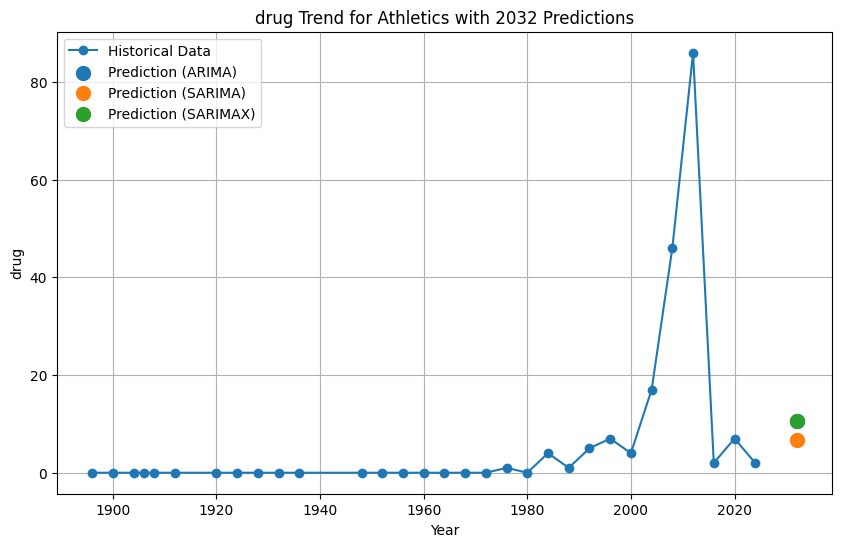

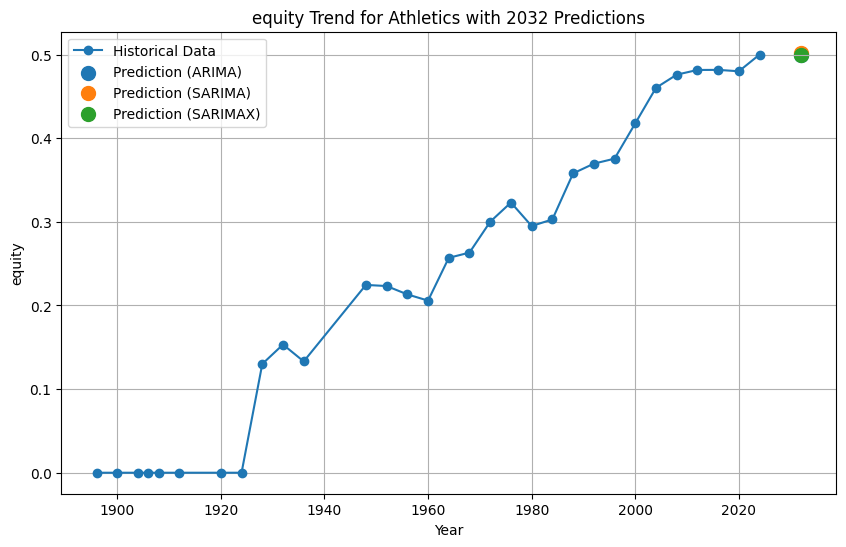

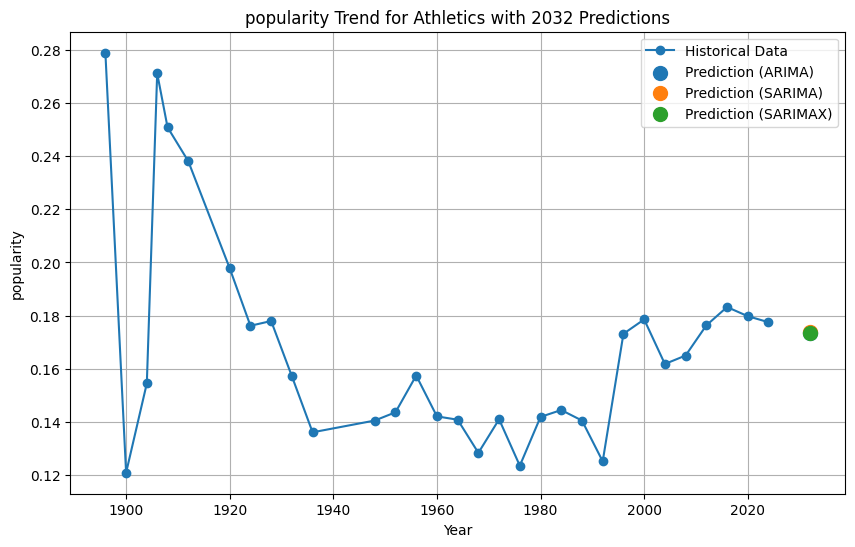

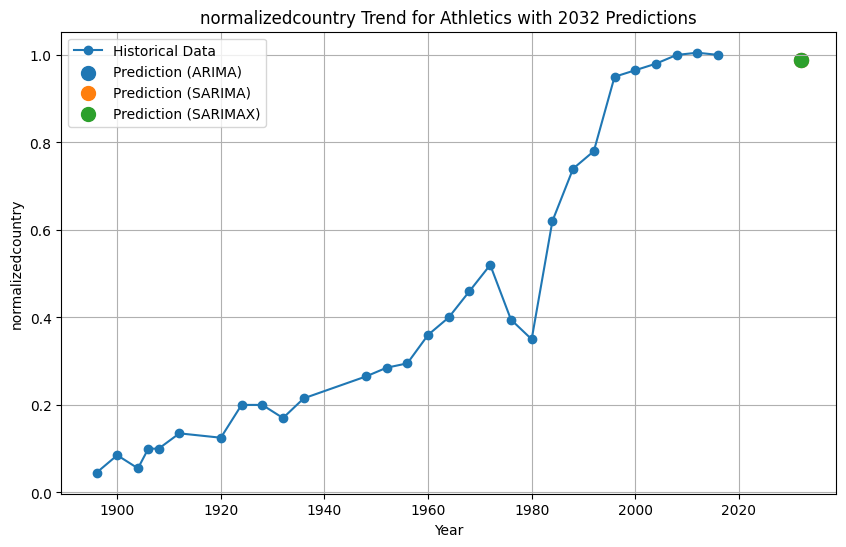

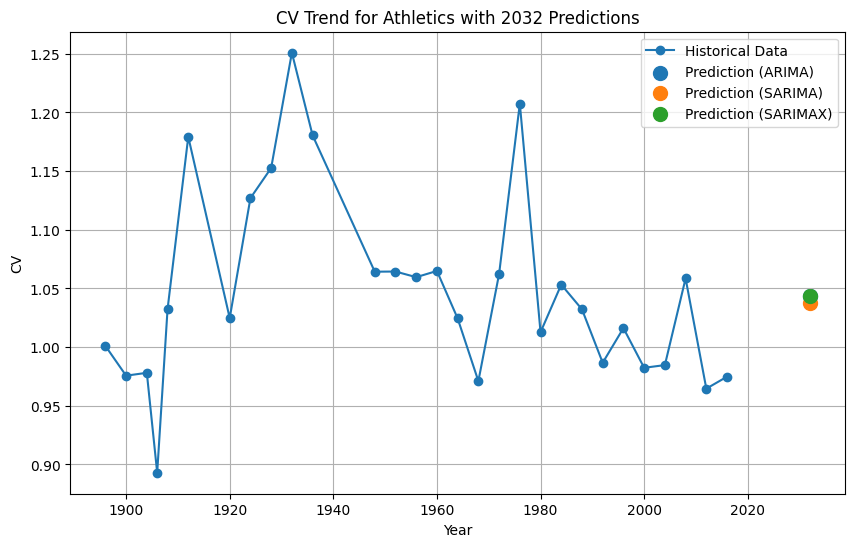

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the predictions data
predictions_df = pd.read_csv('predictions_2032.csv')

# Filter data for Athletics sport
athletics_df = predictions_df[predictions_df['Sport'] == 'Athletics']

# Plot for each parameter
parameters = athletics_df['Parameter'].unique()

for parameter in parameters:
    plt.figure(figsize=(10, 6))

    # Filter for specific parameter
    original_data = sport_data_dict['Athletics'][['Year', parameter]].dropna()
    plt.plot(original_data['Year'], original_data[parameter], label='Historical Data', marker='o')

    # Get prediction data for 2032
    pred_2032 = athletics_df[athletics_df['Parameter'] == parameter]
    
    for model in pred_2032['Model'].unique():
        prediction_value = pred_2032[pred_2032['Model'] == model]['Prediction_2032'].values[0]
        plt.scatter(2032, prediction_value, label=f'Prediction ({model})', s=100)
    
    plt.title(f'{parameter} Trend for Athletics with 2032 Predictions')
    plt.xlabel('Year')
    plt.ylabel(parameter)
    plt.legend()
    plt.grid(True)
    plt.show()


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the predictions data
predictions_df = pd.read_csv('predictions_2032.csv')

# Create a directory to save the plots
output_dir = 'sport_plots'
os.makedirs(output_dir, exist_ok=True)

# Create a new column for plot paths
predictions_df['Plot_Path'] = ''

# Loop over each unique sport
for sport in predictions_df['Sport'].unique():
    # Filter predictions for this sport
    sport_predictions = predictions_df[predictions_df['Sport'] == sport]
    
    # Retrieve the corresponding DataFrame from sport_data_dict
    sport_data = sport_data_dict[sport]
    
    for parameter in sport_predictions['Parameter'].unique():
        plt.figure(figsize=(10, 6))
        
        # Filter historical data for the parameter
        historical_data = sport_data[['Year', parameter]].dropna()
        
        if not historical_data.empty:
            plt.plot(historical_data['Year'], historical_data[parameter], label='Historical Data', marker='o')
        
        # Get prediction data for 2032
        param_predictions = sport_predictions[sport_predictions['Parameter'] == parameter]
        
        for model in param_predictions['Model'].unique():
            prediction_value = param_predictions[param_predictions['Model'] == model]['Prediction_2032'].values[0]
            plt.scatter(2032, prediction_value, label=f'Prediction ({model})', s=100)
        
        plt.title(f'{parameter} Trend for {sport} with 2032 Predictions')
        plt.xlabel('Year')
        plt.ylabel(parameter)
        plt.legend()
        plt.grid(True)
        
        # Save the plot
        plot_path = os.path.join(output_dir, f'{sport}_{parameter}_trend.png')
        plt.savefig(plot_path)
        plt.close()
        
        # Assign the plot path to the relevant rows in predictions_df
        predictions_df.loc[
            (predictions_df['Sport'] == sport) & (predictions_df['Parameter'] == parameter),
            'Plot_Path'
        ] = plot_path


print("All plots saved and DataFrame updated with plot paths.")


All plots saved and DataFrame updated with plot paths.
